# District Level Relationships with Income Tax Data V2

** The following report uses IRS income tax data summarized by NC school district to explore the relationships between income tax data and various school district statistics.  **

** Data Sources: **
* This report uses NC school district data from the 2016-2017 school year.
* This report income tax data summarized by zip code from the 2016 tax year.
* Zip codes for each public school campus are used to summarize income tax data by school district.
* Source code and details for these datasets are located here: 
 * https://github.com/jakemdrew/EducationDataNC/tree/master/2017/School%20Datasets

** Report Details: **
* Each report charts a single income tax variable summarized by school district with 42 district level variables considered for all school districts in North Carolina.  
* Individual regression lines are fit to each pairwise combination of income tax and school district variables. 
* Pearson correlation coefficients are calculated and all statistically significant relationships (p <= 0.05) are reported. 
* Kernel Density Estimates (KDE charts) are provided for the vertical and horizontal axis of each chart.  These show the estimated densities (PDF - Probability density functions) for individual values between the min and max value ranges of each variable.   

** Income Tax Features Explored: **
* **Avg Adj Gross Income** - The average total adjusted gross income reported on IRS income taxes by school district.
* **Pct of Anticipation Loans** -  The percentage of anticipation loans claimed on IRS income taxes by school district. 
* **Pct of Anticipation Checks** -  The percentage of anticipation checks claimed on IRS income taxes by school district.
* **Pct of Elderly Returns** - The percentage of elderly returns filed by school district.

## Cleaning Up the Data

In [6]:
#import required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

year = '2017'
irsDsName = 'IncomeTaxDataBySchoolDistrict_2016.csv'
schoolDsName = 'PublicSchools2017.csv'

#Read in IRS data by school district
path='C:/Users/Jake/Documents/GitHub/EducationDataNC/'  + year + '/School Datasets/' + irsDsName
irsData=pd.read_csv(path, low_memory=False)

#Read in high school data
path='C:/Users/Jake/Documents/GitHub/EducationDataNC/' + year + '/School Datasets/' + schoolDsName
schoolData=pd.read_csv(path, low_memory=False)

In [7]:
#Inspect IRS data fields available
#irsData.info(verbose=True)

In [8]:
#Isolate school district level columns
leaCols = schoolData.columns[schoolData.columns.str.lower().str.contains('lea_')]
distSchoolData = schoolData[leaCols]

#Get first non-null value for each district level field 
#(School district level data is duplicated for each campus in district)
distSchoolData = distSchoolData.groupby('Lea_Name').first()

#Inspect school district data fields selected
#distSchoolData.info(verbose=True)

In [9]:
#Isolate irs data totals
irsTotCols = irsData.columns[irsData.columns.str.contains(' All')]
irsTotCols = irsTotCols.append(pd.Index(['Lea_Name']))
irsSummaryData = irsData[irsTotCols]

In [10]:
#Inspect IRS summary data fields selected
#irsSummaryData.info(verbose=True)

In [11]:
print('*********************************Start: Merge IRS and School District Data*********************************')
irsSummaryData.info(verbose=False)
print(' ')
distSchoolData.info(verbose=False)
print(' ')

#Merge profile and profileMetric data
irsSchoolDistData = irsSummaryData.merge(distSchoolData,how='left',on='Lea_Name', suffixes=('', '_Drop'))

print('*********************************After: Merge IRS and School District Data**************************')
irsSchoolDistData.info(verbose=False)

*********************************Start: Merge IRS and School District Data*********************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Columns: 144 entries, (TCE) prepared returns Ct All to Lea_Name
dtypes: float64(143), object(1)
memory usage: 130.6+ KB
 
<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, Alamance-Burlington Schools to Yancey County Schools
Columns: 53 entries, lea_avg_student_num to 4-10 Years_LEA_Exp_Pct_Prin
dtypes: float64(53)
memory usage: 48.9+ KB
 
*********************************After: Merge IRS and School District Data**************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 115
Columns: 197 entries, (TCE) prepared returns Ct All to 4-10 Years_LEA_Exp_Pct_Prin
dtypes: float64(196), object(1)
memory usage: 179.4+ KB


In [12]:
#Create new IRS average fields
irsSchoolDistData['Avg Tot Income'] = irsSchoolDistData['Tot income Amt All'] / irsSchoolDistData['Tot income Ct All']

irsSchoolDistData['Avg Dependents Per Ret'] = irsSchoolDistData['Number of dependents All']\
                                              / irsSchoolDistData['Number of returns All']

irsSchoolDistData['Avg Personal Property Taxes'] = irsSchoolDistData['Personal property taxes Amt All']\
                                              / irsSchoolDistData['Personal property taxes Ct All']

irsSchoolDistData['Pct of Farm Returns'] = irsSchoolDistData['Number of farm returns All']\
                                              / irsSchoolDistData['Number of returns All']    
    
# Create IRS average fields report #2
irsSchoolDistData['Avg Adj Gross Income'] = irsSchoolDistData['Adjusted gross income (AGI) All'] / irsSchoolDistData['Number of returns All']

irsSchoolDistData['Pct of Anticipation Loans']  = irsSchoolDistData['Number of refund anticipation loan returns All']\
                                              / irsSchoolDistData['Number of returns All']  
    
irsSchoolDistData['Pct of Anticipation Checks']  = irsSchoolDistData['Number of refund anticipation check returns All']\
                                              / irsSchoolDistData['Number of returns All']  

irsSchoolDistData['Pct of Elderly Returns'] = irsSchoolDistData['Number of elderly returns All'] / irsSchoolDistData['Number of returns All']


## Visualizing District Level Features

In [13]:
#Create a function to plot regression lines for two variables
def PlotJoint(x,y,data):
    sns.set(context='notebook', style='darkgrid', font_scale=1.25)
    my_plot = sns.jointplot(x=x, y=y, data=data, kind="reg");
    my_plot.fig.set_figwidth(8)
    my_plot.fig.set_figheight(8)

In [14]:
#Make a list of 42 district level features to make plots for
leaCols = ['lea_avg_student_num', 'lea_total_expense_num',
           'lea_salary_expense_pct', 'lea_services_expense_pct', 
           'lea_supplies_expense_pct','lea_instruct_equip_exp_pct', 
           'lea_other_expense_pct', 'lea_federal_perpupil_num', 
           'lea_local_perpupil_num', 'lea_state_perpupil_num',
           'lea_sat_avg_score_num', 'lea_sat_participation_pct',
           'lea_ap_participation_pct', 'lea_ap_pct_3_or_above',
           'lea_ib_pct_4_or_above', 'lea_total_specialized_courses',
           'lea_ap_ib_courses', 'lea_cte_courses', 
           'lea_univ_college_courses', 'lea_avg_daily_attend_pct', 
           'lea_crime_per_c_num','lea_short_susp_per_c_num', 
           'lea_long_susp_per_c_num', 'lea_expelled_per_c_num', 
           'lea_stud_internet_comp_num', 'lea_avg_age_media_collection', 
           'lea_books_per_student', 'lea_wap_num', 
           'lea_wap_per_classroom', 'lea_flicensed_teach_pct',
           'lea_tchyrs_0thru3_pct', 'lea_tchyrs_4thru10_pct',
           'lea_tchyrs_11plus_pct', 'lea_class_teach_num', 
           'lea_nbpts_num', 'lea_advance_dgr_pct', 
           'lea_1yr_tchr_trnovr_pct', 'lea_emer_prov_teach_pct', 
           'lea_lateral_teach_pct', '0-3 Years_LEA_Exp_Pct_Prin',
           '10+ Years_LEA_Exp_Pct_Prin', '4-10 Years_LEA_Exp_Pct_Prin']

## District Level Relationships with Average Adjusted Gross Income (1,000's)
** The following charts use IRS income tax data summarized by NC school district explore the relationship between a school district's IRS reported average adjusted gross income and various school district statistics.** 

**Key points to remember:** 
* Correlations are statistically significant at α = 0.05 or lower: they are (highly) unlikely and thus refute the null hypothesis of a zero population correlation.
* Correlations are never lower than -1. A correlation of -1 indicates that the data points in a scatter plot lie exactly on a straight descending line; the two variables are perfectly negatively linearly related.
* A correlation of 0 means that two variables don't have any linear relation whatsoever. However, some non linear relation may exist between the two variables.
* Correlation coefficients are never higher than 1. A correlation coefficient of 1 means that two variables are perfectly positively linearly related; the dots in a scatter plot lie exactly on a straight ascending line.
* 'Avg Tot Income' = 'Tot income Amt All' / 'Tot income Ct All'

**Key observations include statistically significant positive / negative correlations and are as follows: **
* District total expenses decrease as Average Adjusted Gross Income increases.
* District salaries as a percent of total expenses increase as Average Adjusted Gross Income increases.
* District supplies as a percent of total expenses decrease as Average Adjusted Gross Income increases.
* District federal funding per pupil decreases significantly as Average Adjusted Gross Income increases.
* District local funding per pupil increases significantly as Average Adjusted Gross Income increases.
* District state funding per pupil decreases as Average Adjusted Gross Income increases.
* District average SAT scores increase significantly as Average Adjusted Gross Income increases.
* District average SAT participation percentages increase as Average Adjusted Gross Income increases.
* District AP participation percentages increase significantly as Average Adjusted Gross Income increases.
* District AP pct 3 or above increases as Average Adjusted Gross Income increases.
* District AP IB courses increase significantly as Average Adjusted Gross Income increases.
* District CTE courses decrease as Average Adjusted Gross Income increases.
* District univ college courses decrease as Average Adjusted Gross Income increases.
* District average daily attendance percentages increase as Average Adjusted Gross Income increases.
* District crime, short and long term suspensions, and expulsions do not appear to be correlated with Average Adjusted Gross Income changes. 
* District student internet connected computer numbers increase as Average Adjusted Gross Income increases.
* The average age of a district's media collection increases as Average Adjusted Gross Income increases.
* District total wireless access points increase as Average Adjusted Gross Income increases. 
* District fully licensed teachers increase as Average Adjusted Gross Income increases.
* District teach experience levels does not seem to be correlated  do not appear to be correlated with Average Adjusted Gross Income changes. 
* District class teacher numbers increase as Average Adjusted Gross Income increases.
* District average number of National Board Certified Staff increase as Average Adjusted Gross Income increases.
* The district's percentage of advanced degrees increase as Average Adjusted Gross Income increases.
* District lateral entry teacher percentages decrease as Average Adjusted Gross Income increases.
* District principals with 0-3 years experience decreases as Average Adjusted Gross Income increases.
* District principals with 10+ years experience increases as Average Adjusted Gross Income increases.
* District principals with 4-10 years experience increases as Average Adjusted Gross Income increases.

### Click on the left side of the charts cell output below to expand all charts for viewing!

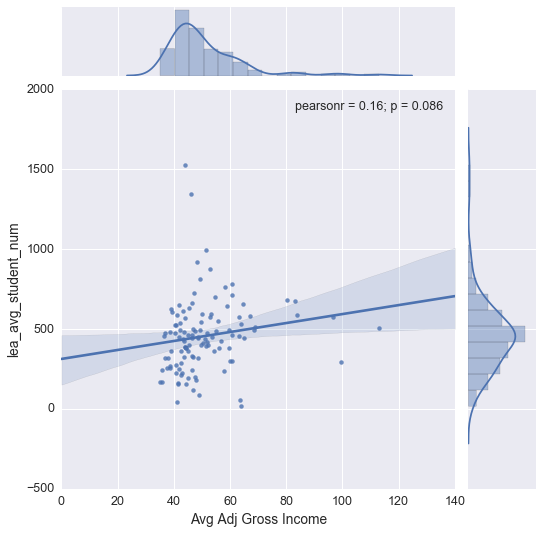

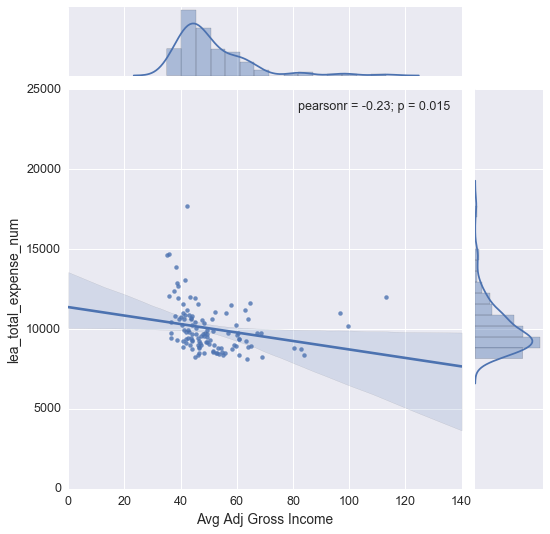

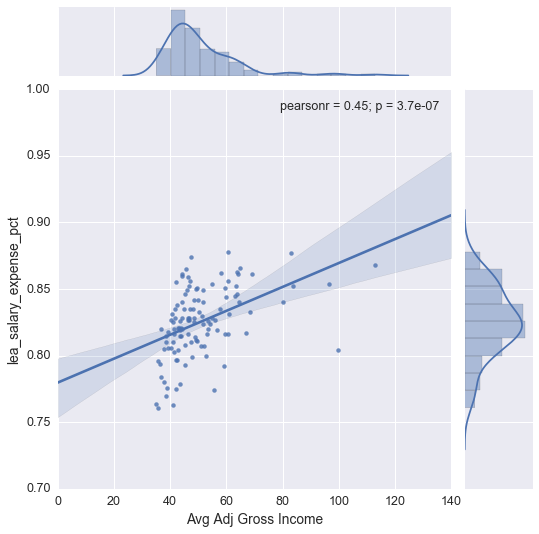

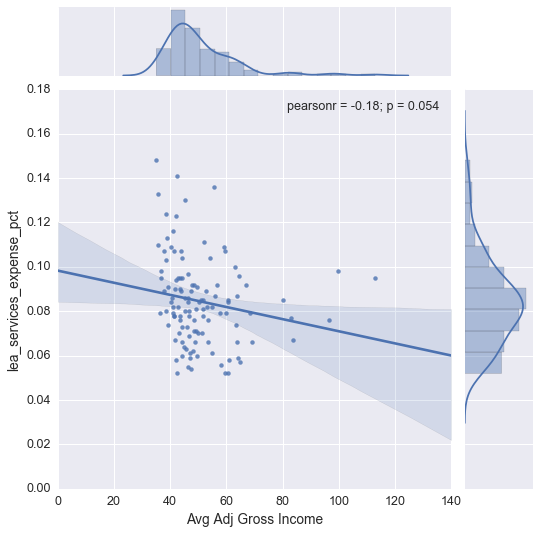

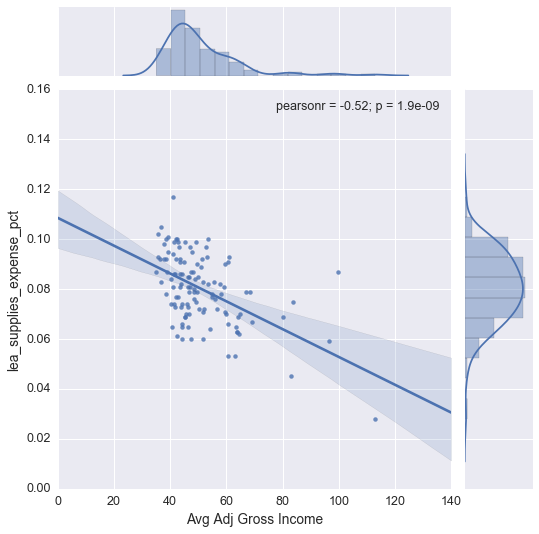

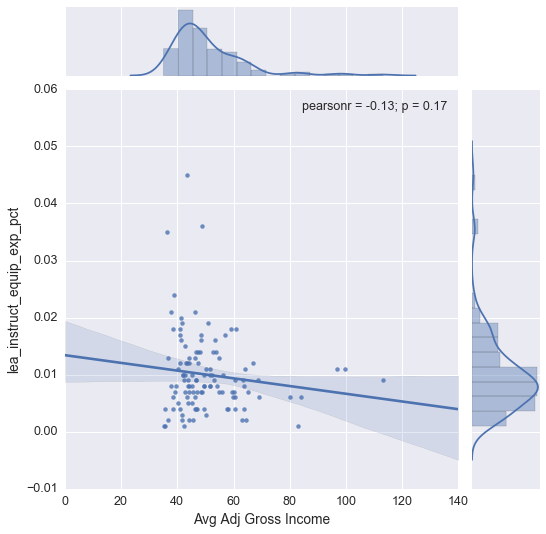

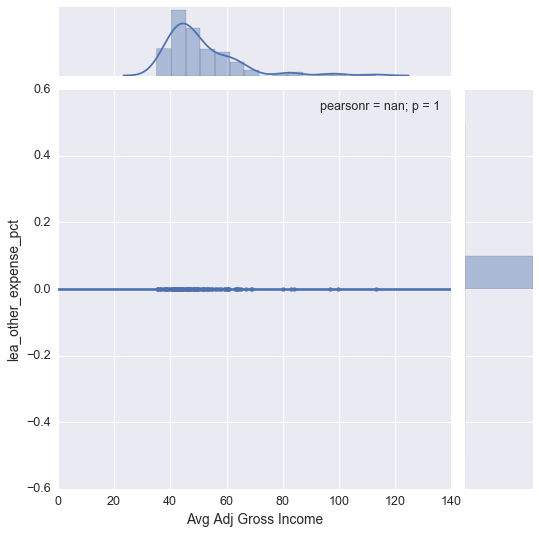

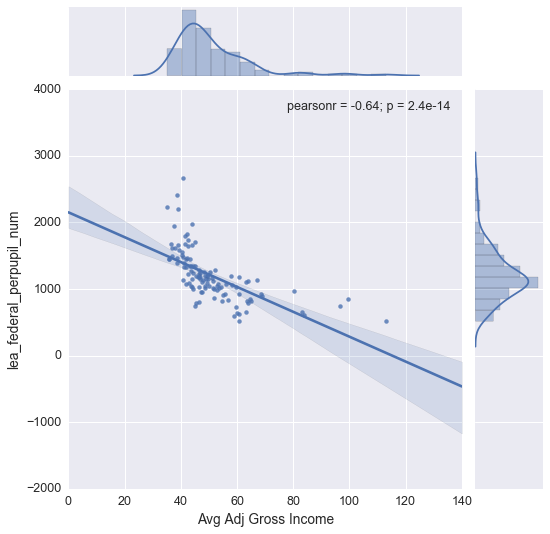

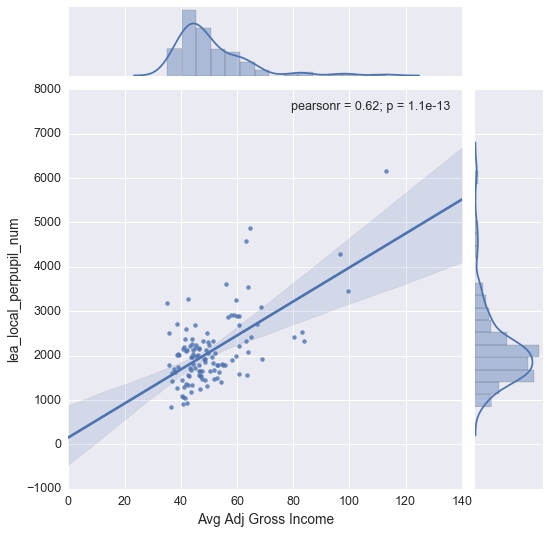

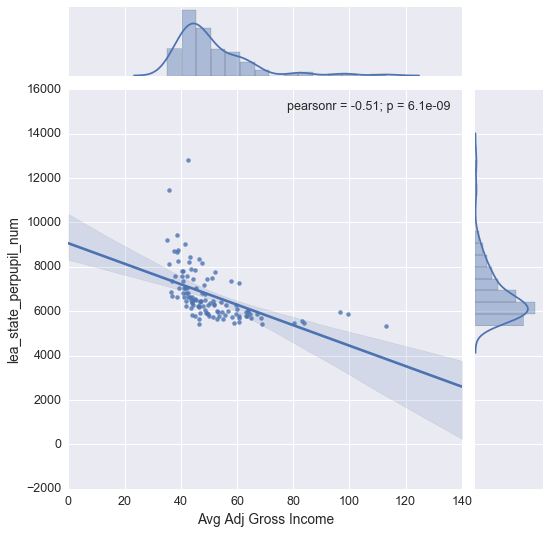

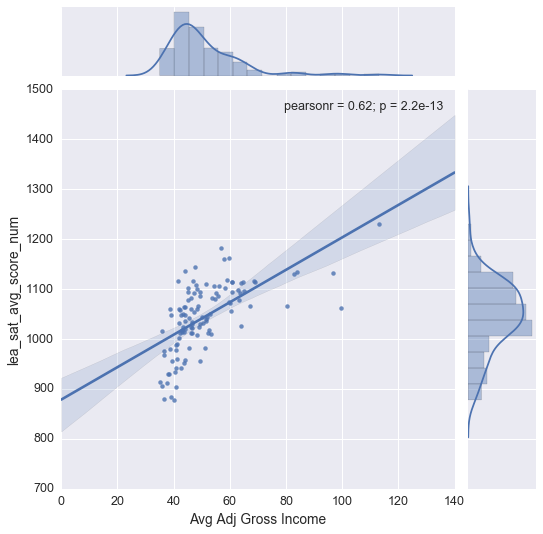

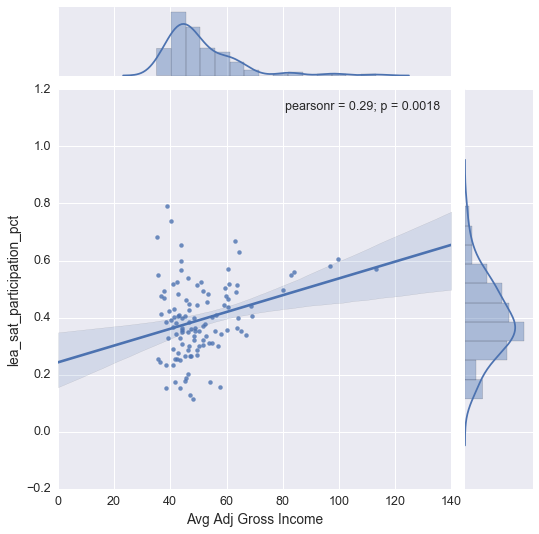

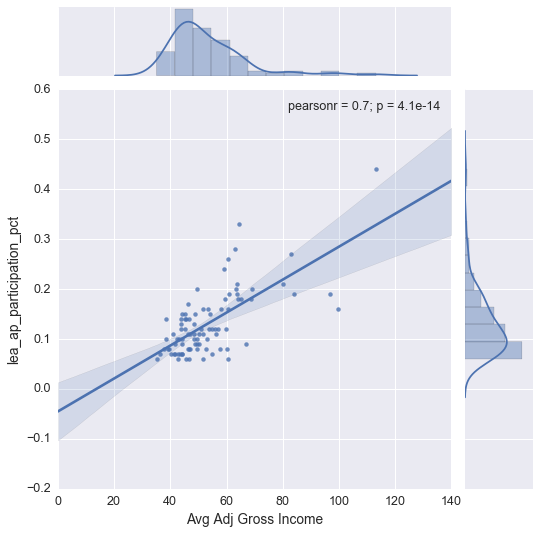

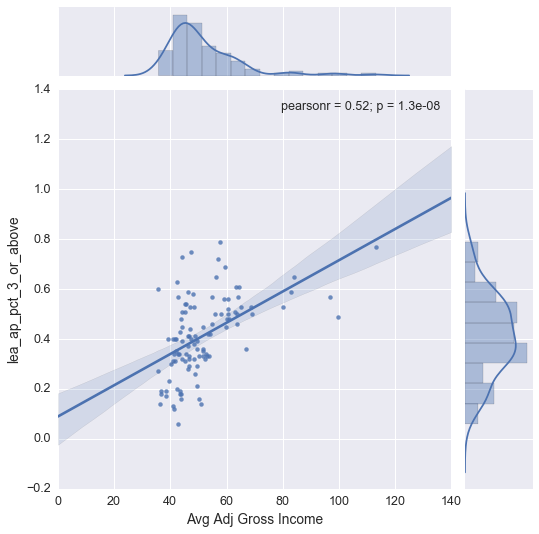

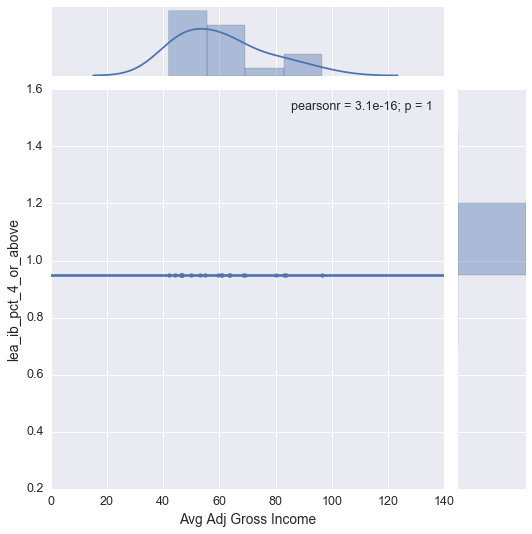

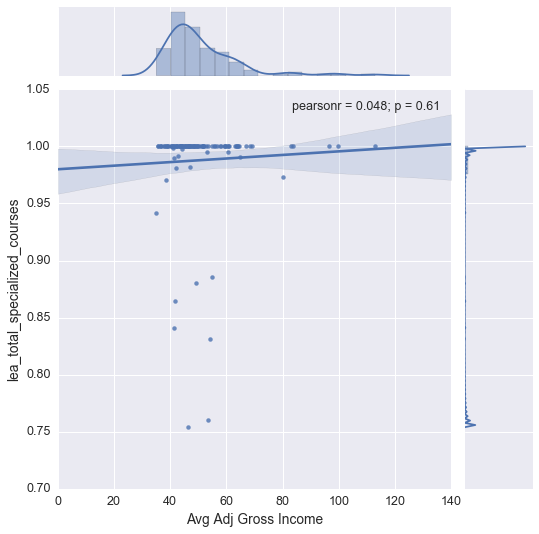

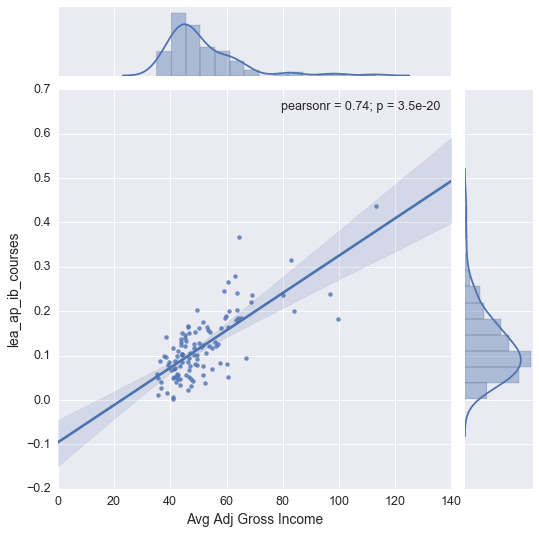

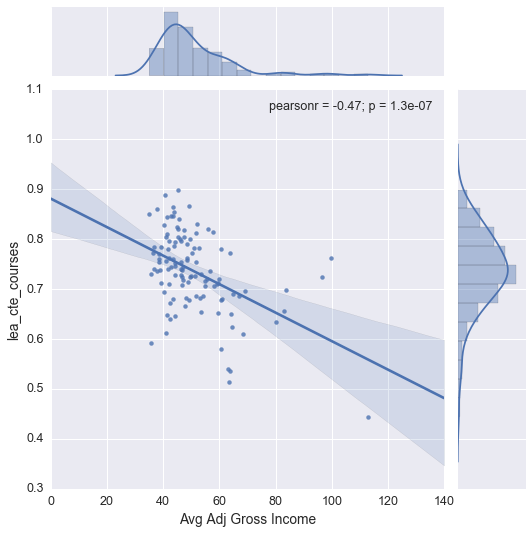

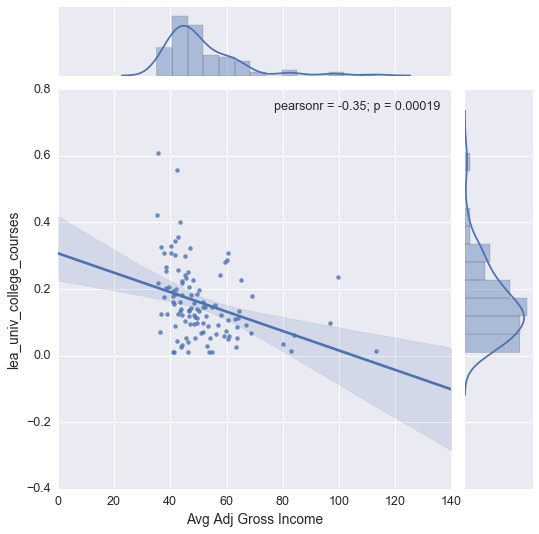

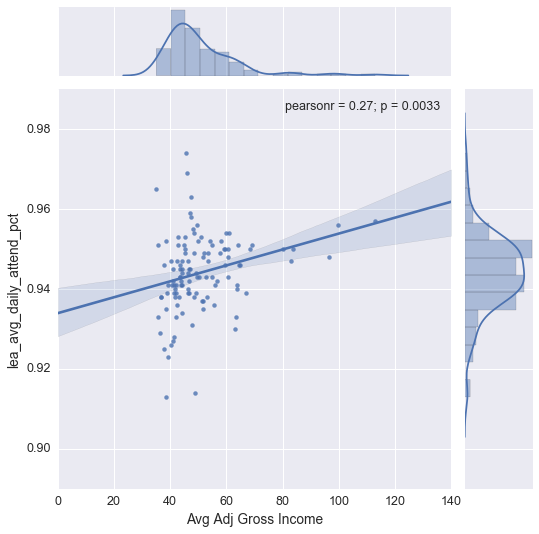

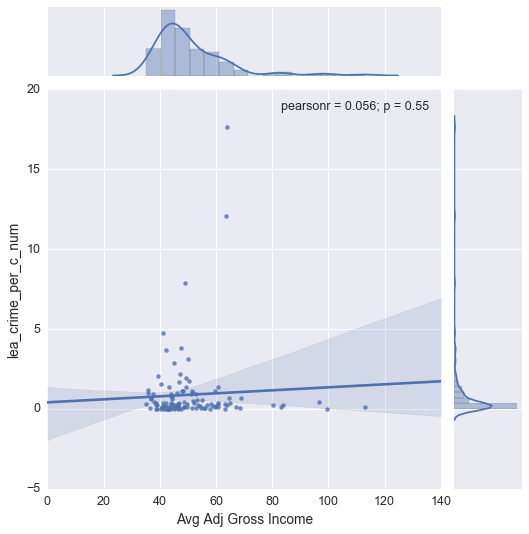

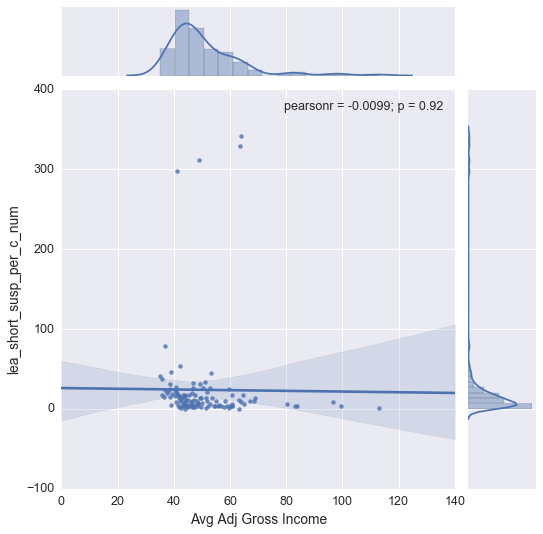

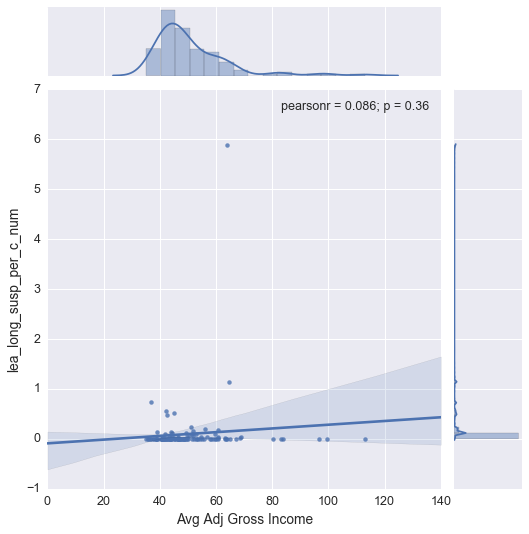

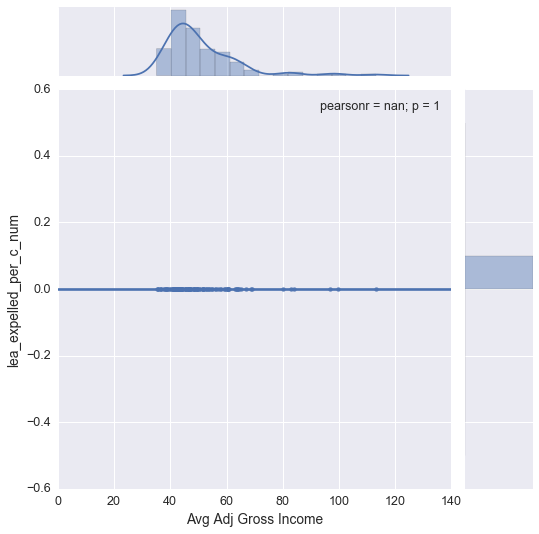

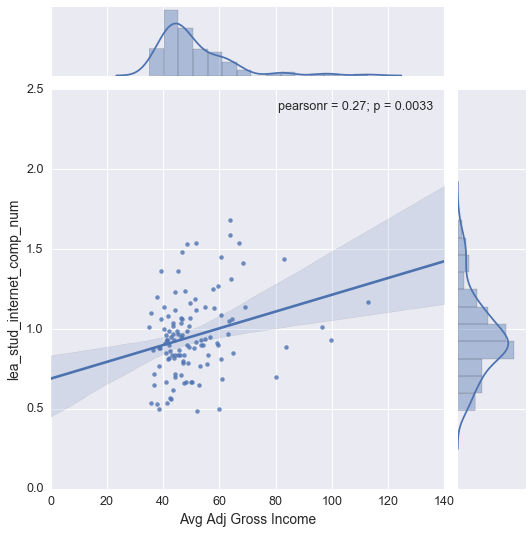

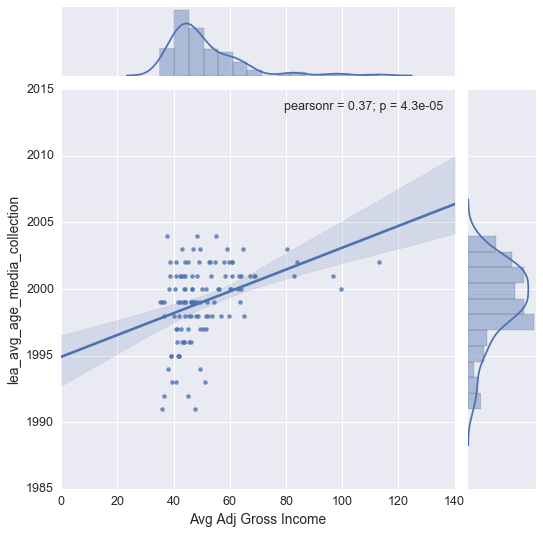

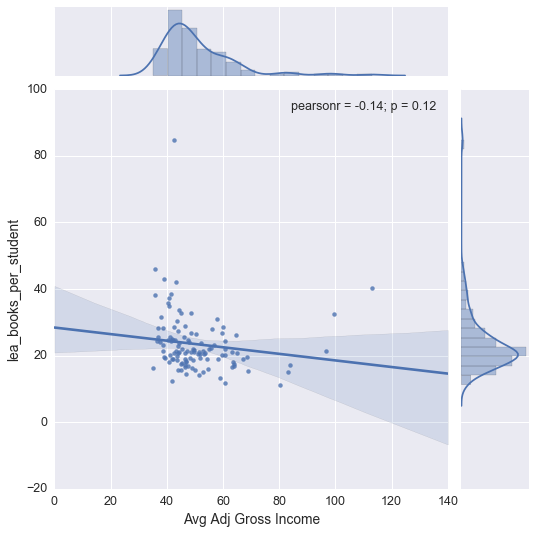

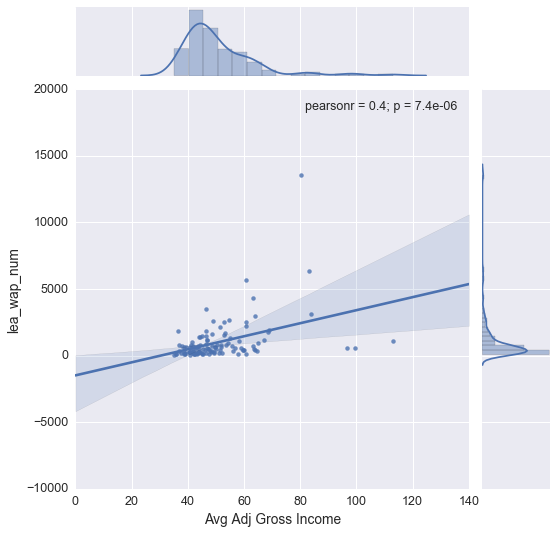

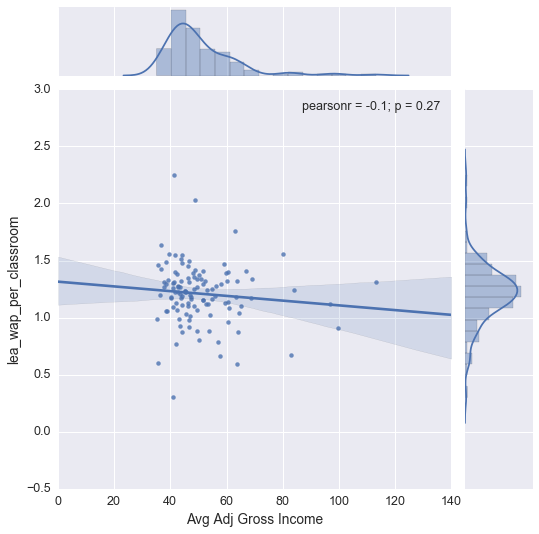

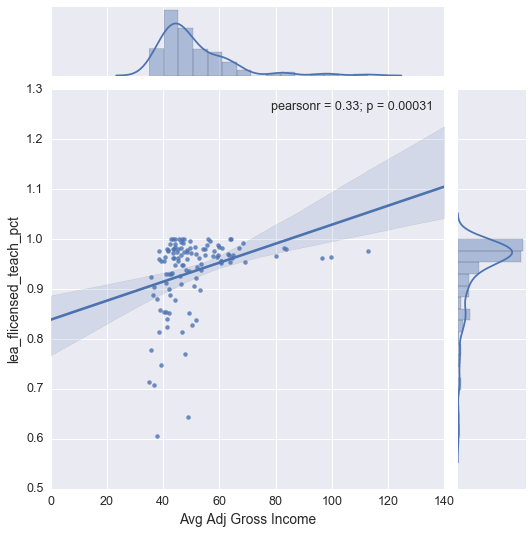

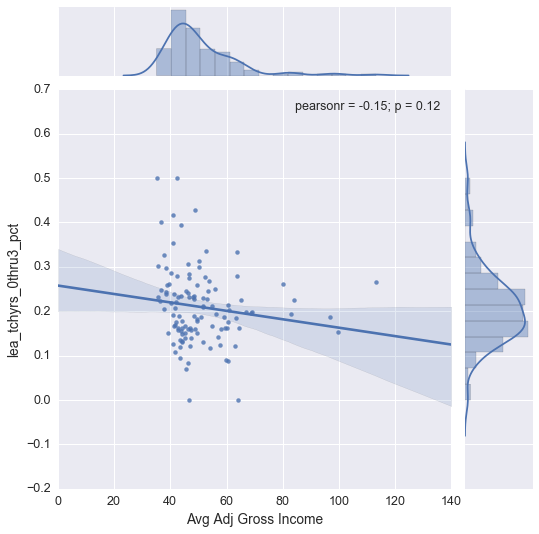

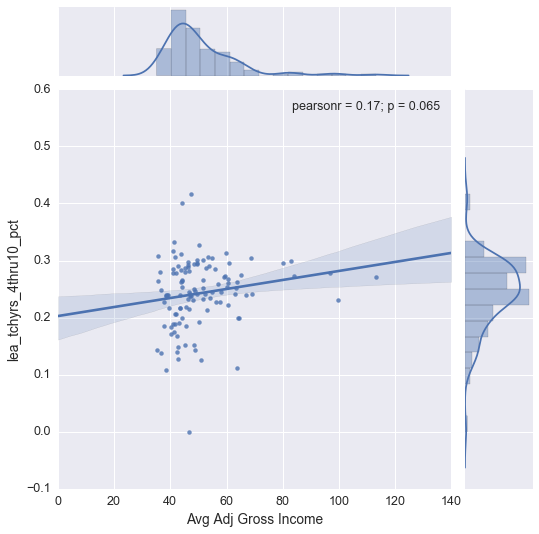

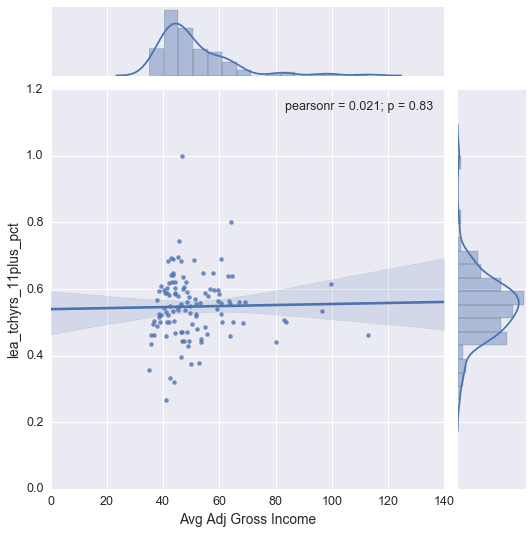

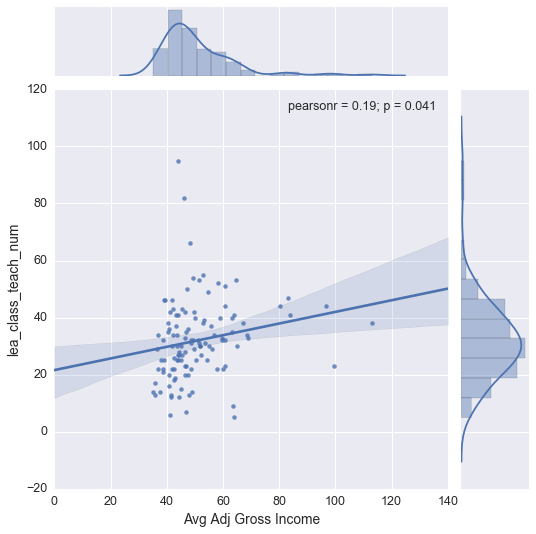

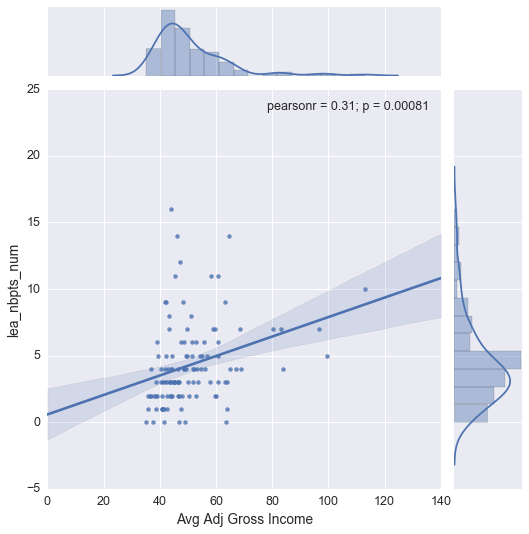

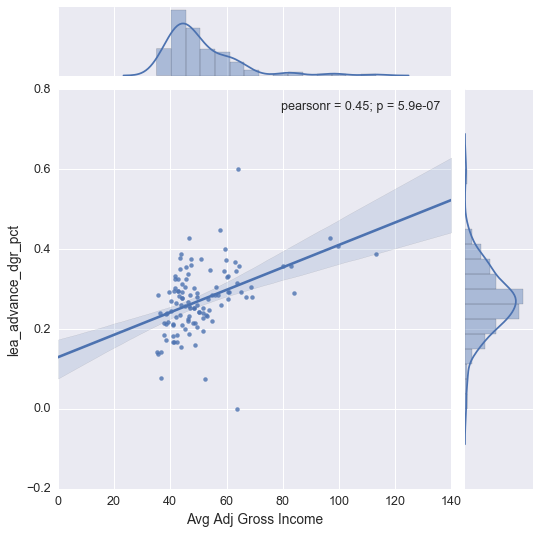

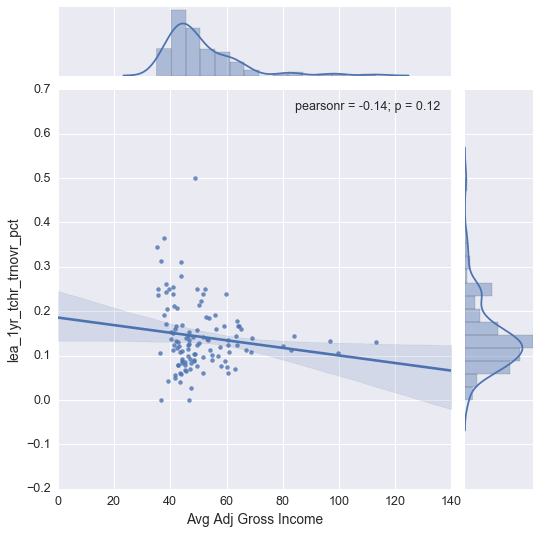

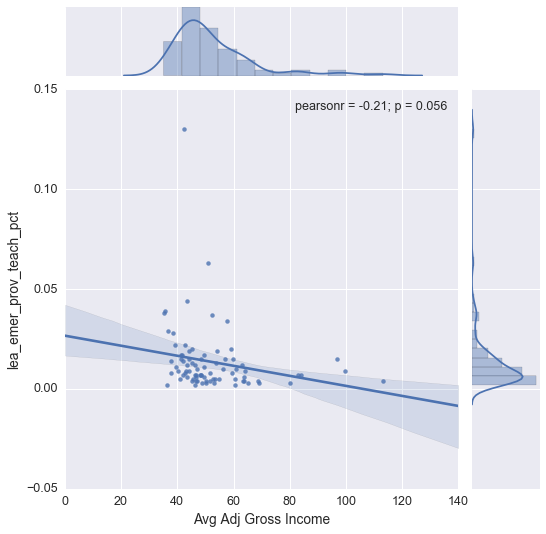

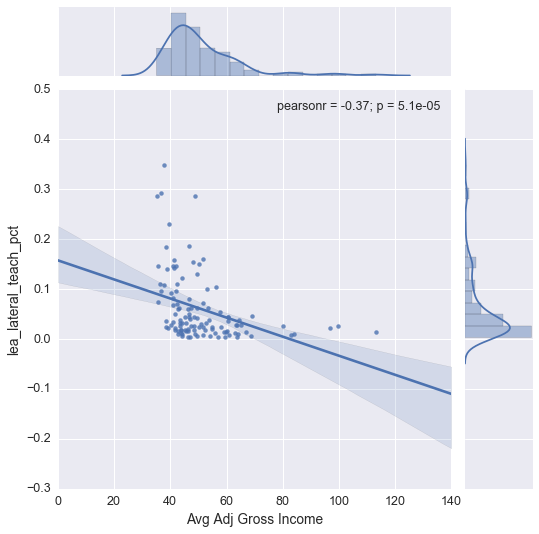

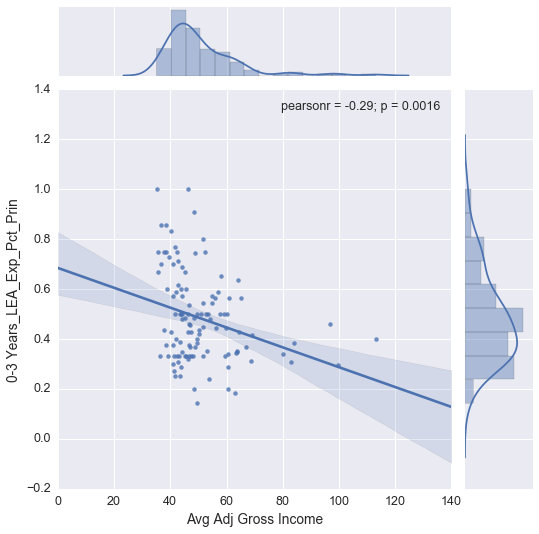

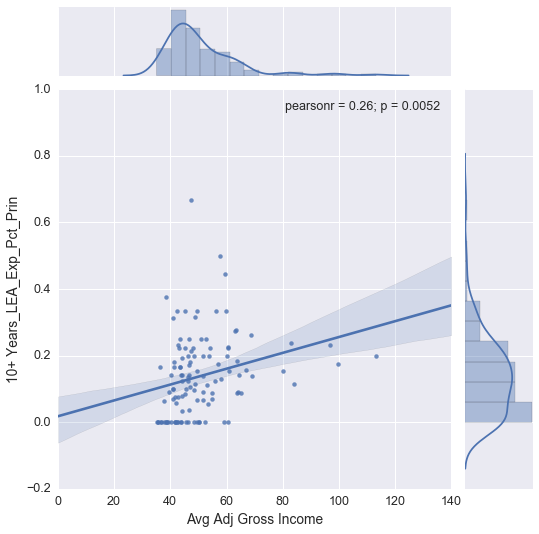

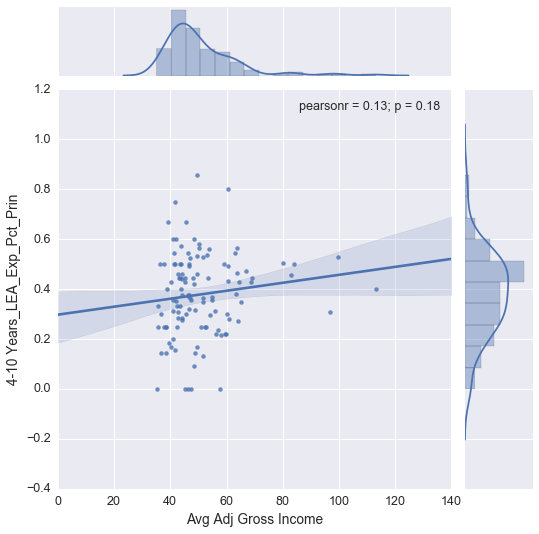

In [24]:
#Create district level charts to compare against Avg Tot Income
for col in leaCols:
    try:
        PlotJoint(x='Avg Adj Gross Income',y=col, data=irsSchoolDistData)
    except Exception:
        continue

## District Level Relationships with Percentage of Anticipation Loans
** The following charts use IRS income tax data summarized by NC school district explore the relationship between a school district's IRS reported percentage of anticipation loans and various school district statistics.** 

**Key points to remember:** 
* Correlations are statistically significant at α = 0.05 or lower: they are (highly) unlikely and thus refute the null hypothesis of a zero population correlation.
* Correlations are never lower than -1. A correlation of -1 indicates that the data points in a scatter plot lie exactly on a straight descending line; the two variables are perfectly negatively linearly related.
* A correlation of 0 means that two variables don't have any linear relation whatsoever. However, some non linear relation may exist between the two variables.
* Correlation coefficients are never higher than 1. A correlation coefficient of 1 means that two variables are perfectly positively linearly related; the dots in a scatter plot lie exactly on a straight ascending line.
* 'Avg Dependents Per Ret' = 'Number of dependents All' \ 'Number of returns All'


**Key observations include statistically significant positive / negative correlations and are as follows: **
* District salaries as a percent of total expenses decrease as the Percentage of Anticipation Loans increases.
* District supplies as a percent of total expenses increase as the Percentage of Anticipation Loans increases. 
* District federal funding per pupil increases as the Percentage of Anticipation Loans increases.
* District local funding per pupil decreases significantly as the Percentage of Anticipation Loans increases.
* District average SAT scores decrease significantly as the Percentage of Anticipation Loans increases.
* District average SAT participation percentages decrease as Average Adjusted Gross Income increases.
* District AP participartion percentages decrease as the Percentage of Anticipation Loans increases.
* District AP PCT 3 or above decreases as the Percentage of Anticipation Loans increases.
* District AP IB courses decrease as the Percentage of Anticipation Loans increases.
* District CTE courses increase as the Percentage of Anticipation Loans increases.
* District crime, short and long term suspensions, and expulsions do not appear to be correlated with the Percentage of Anticipation Loans.
* District student internet connected computer numbers increase as the Percentage of Anticipation Loans increases.
 The average age of a district's media collection decreases as the Percentage of Anticipation Loans increases. 
* District fully licensed teachers decrease as the Percentage of Anticipation Loans increases.
* The district's percentage of advanced degrees decrease as the Percentage of Anticipation Loans increases.
* District lateral entry teacher percentages increase as the Percentage of Anticipation Loans increases.
* District principals with 10+ years experience decrease as the Percentage of Anticipation Loans increases.

### Click on the left side of the charts cell output below to expand all charts for viewing!

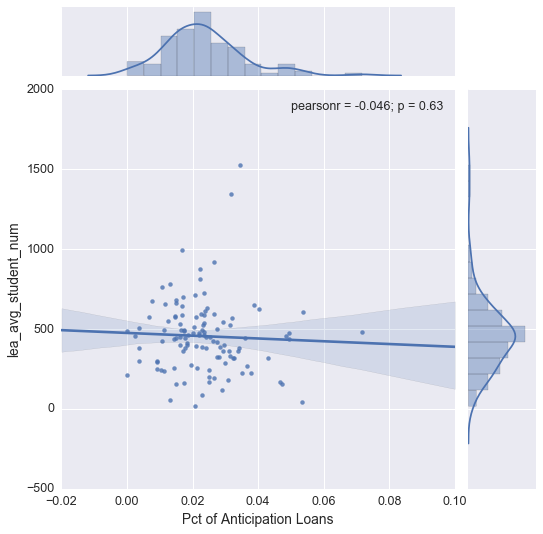

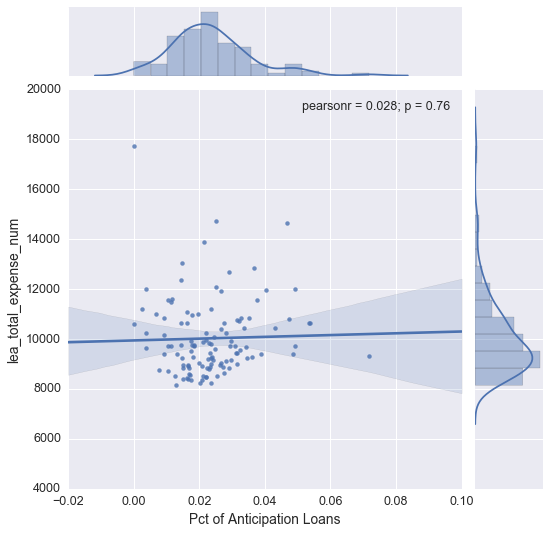

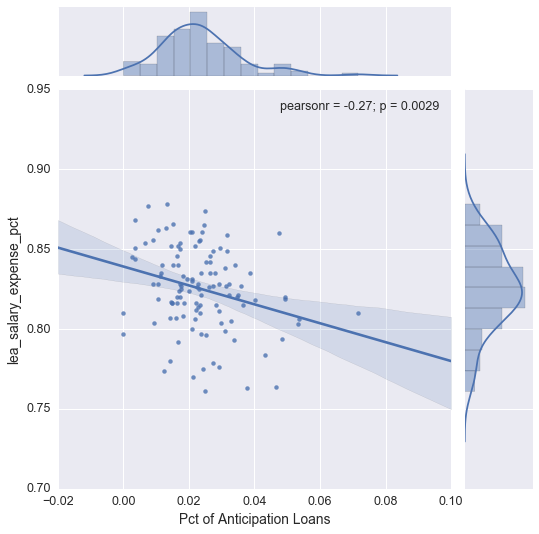

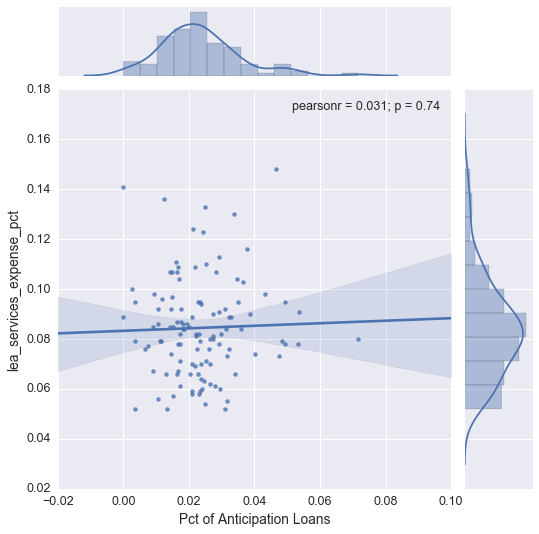

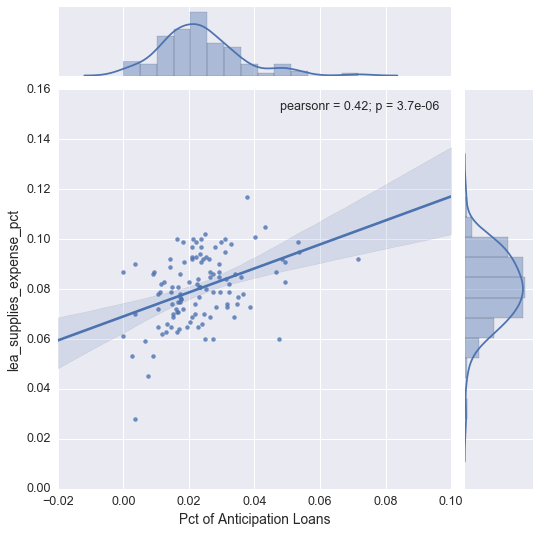

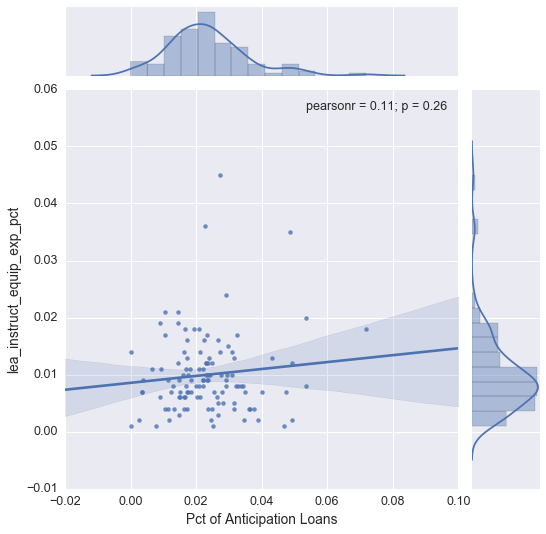

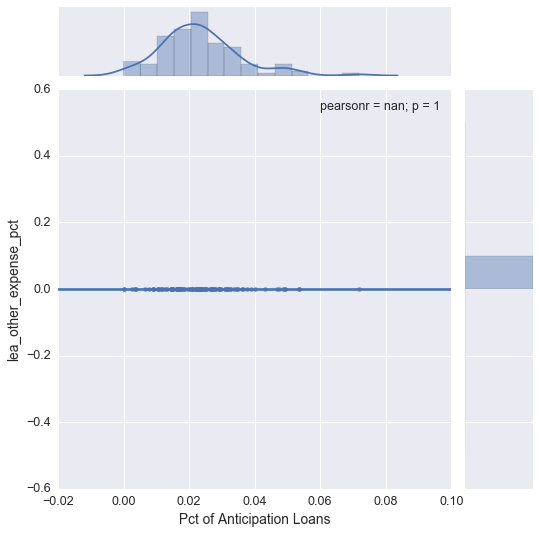

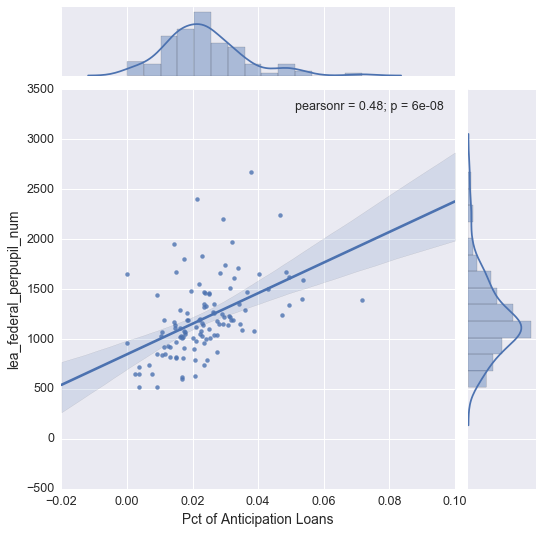

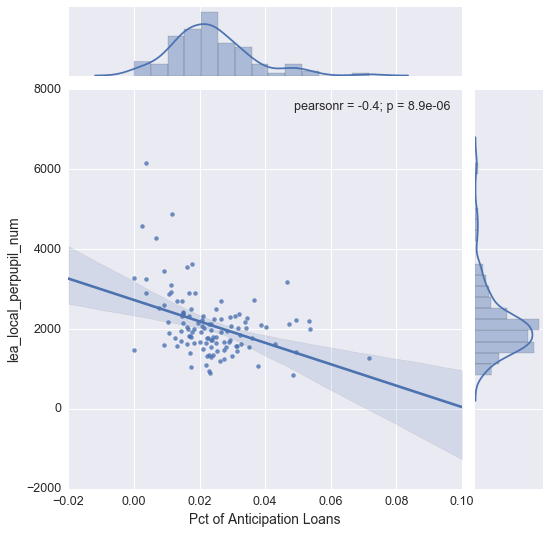

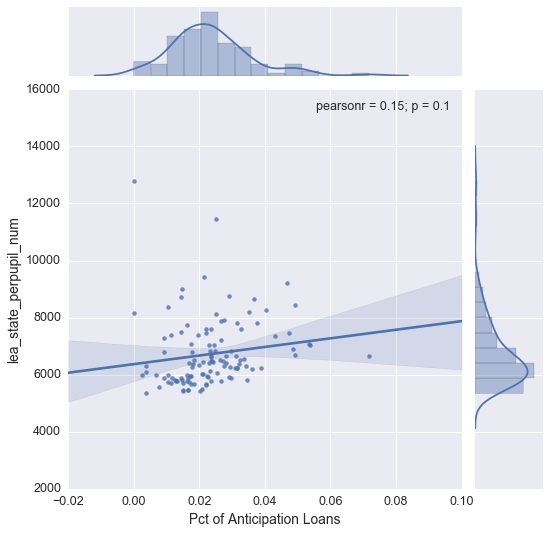

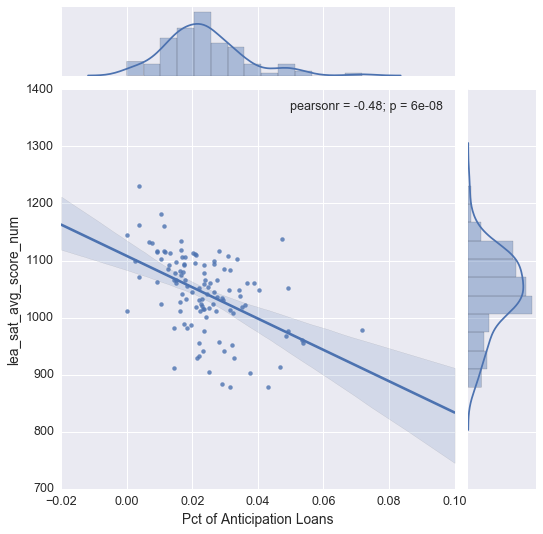

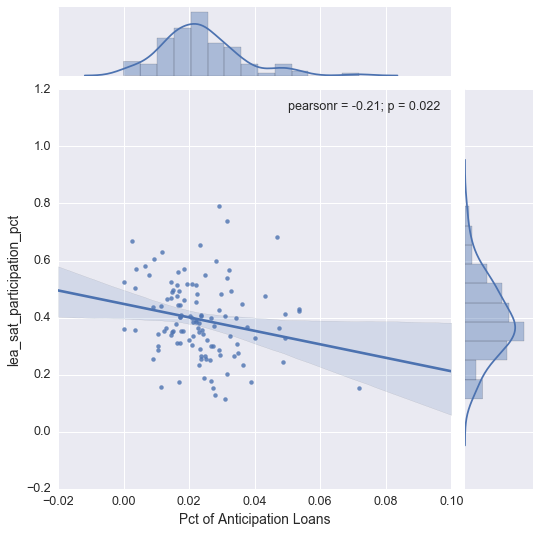

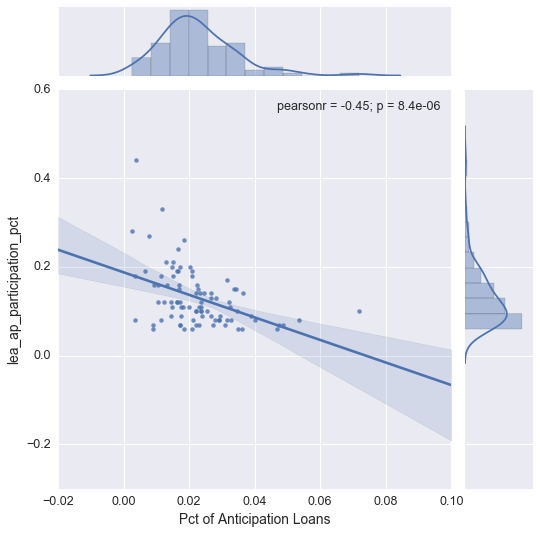

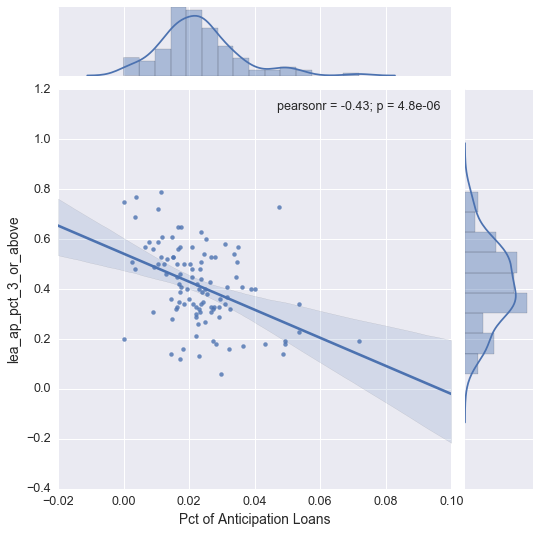

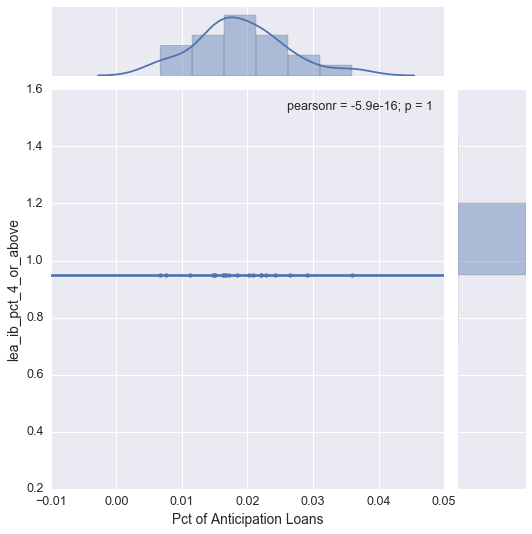

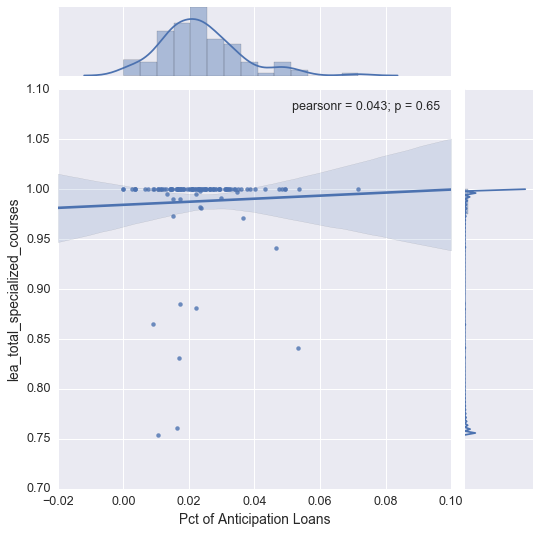

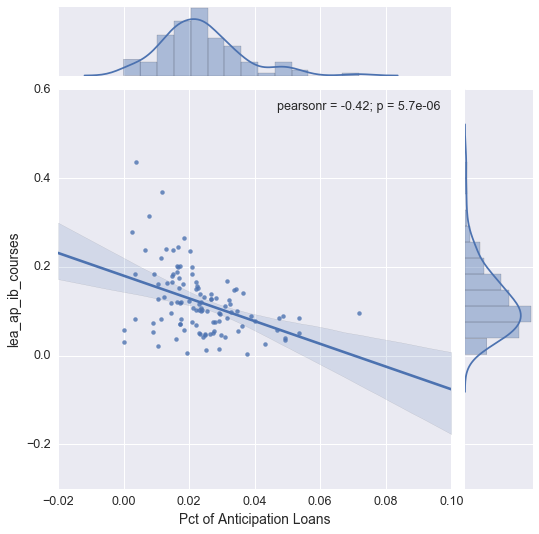

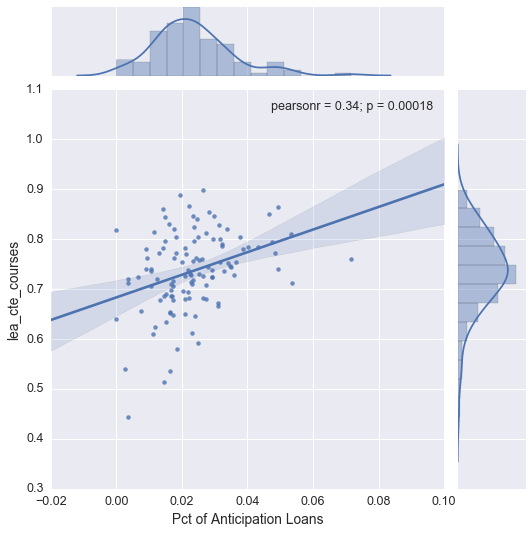

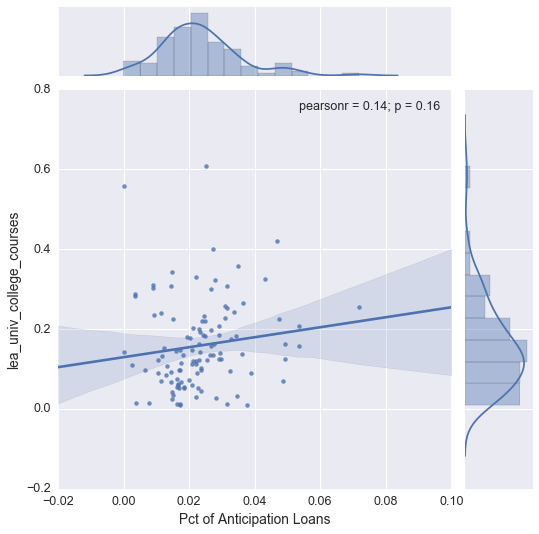

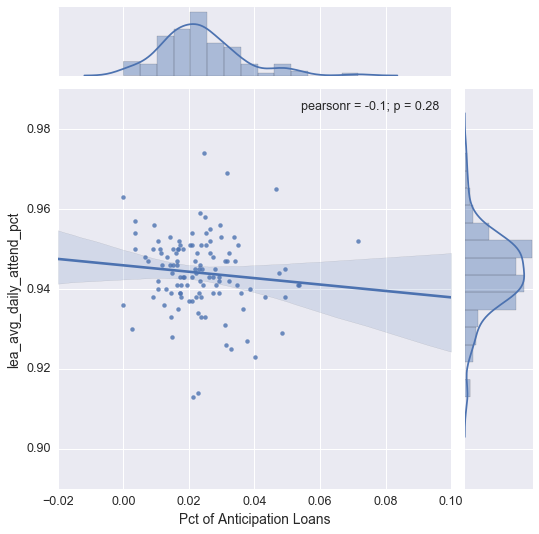

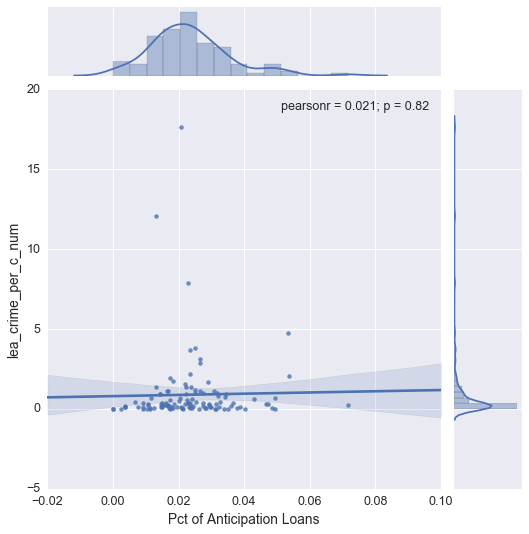

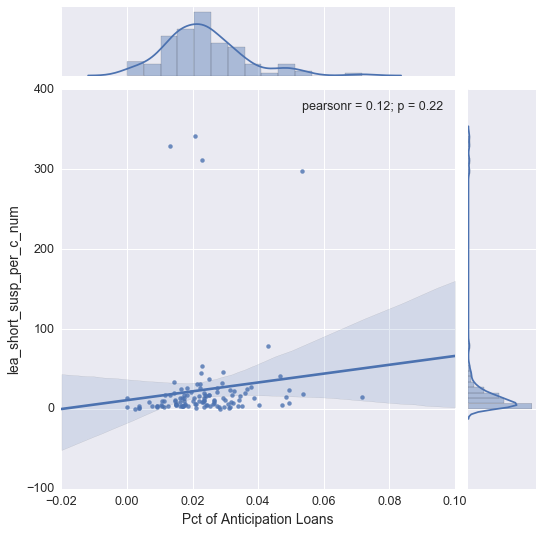

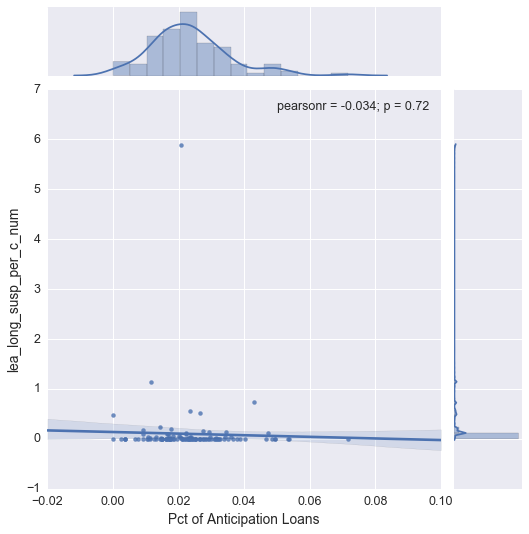

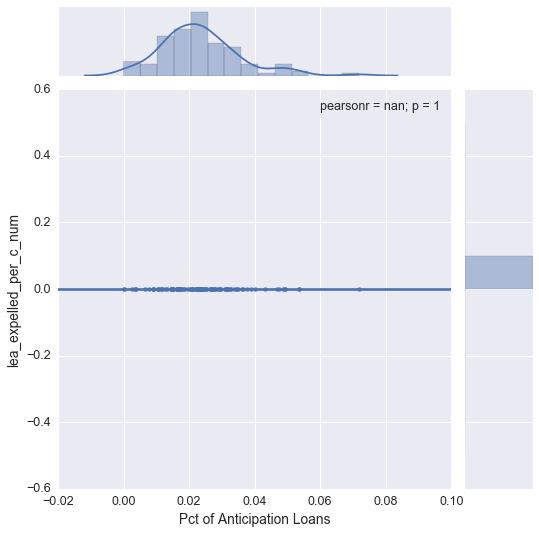

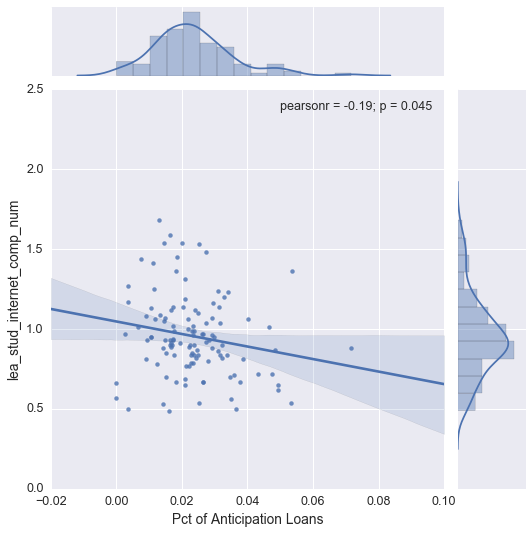

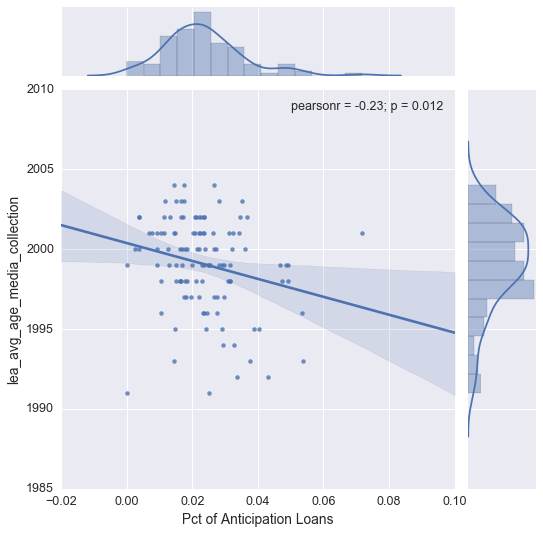

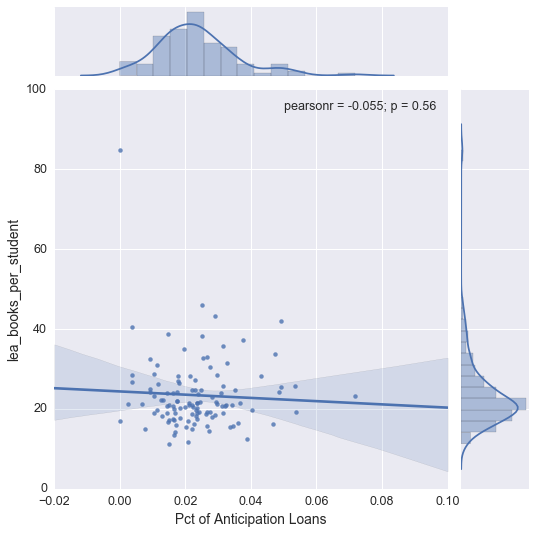

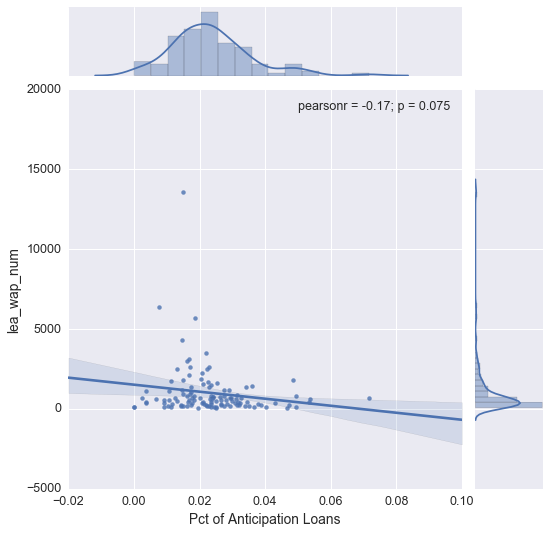

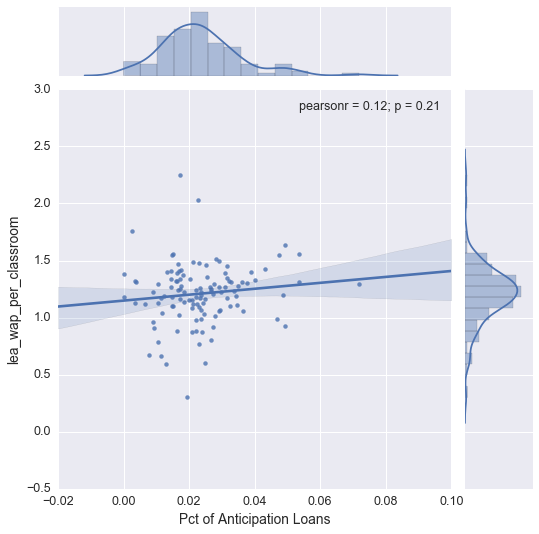

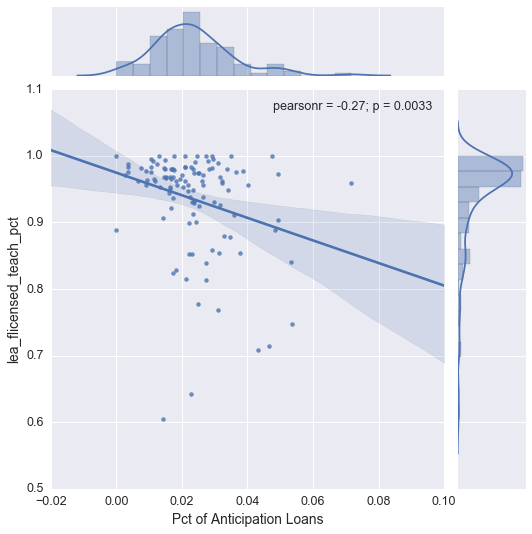

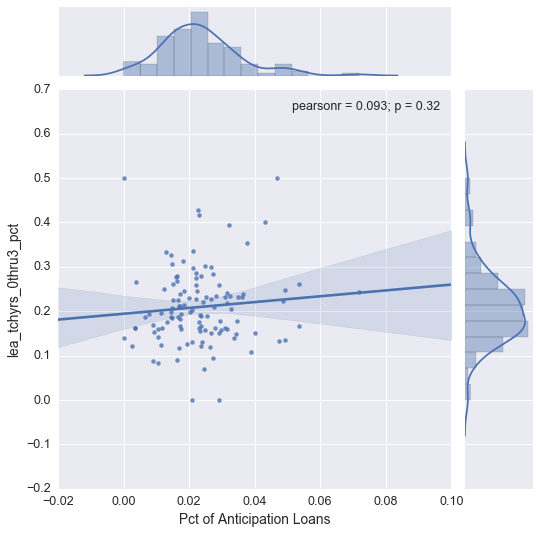

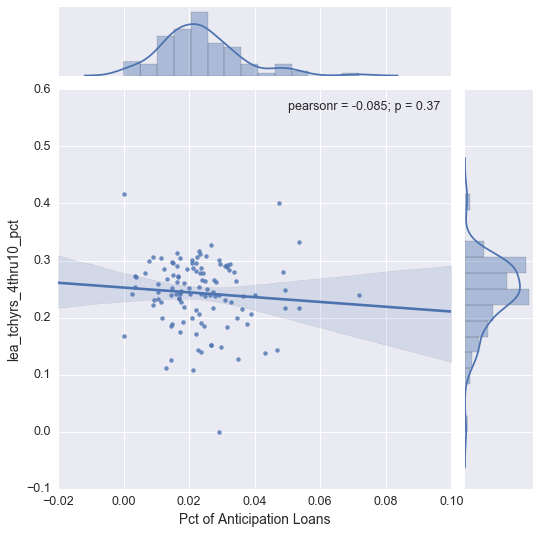

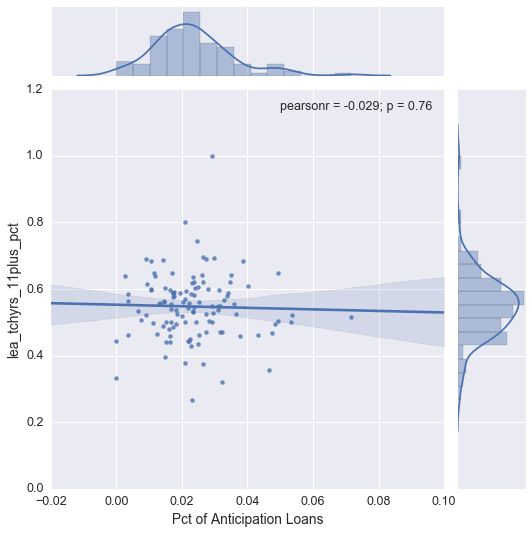

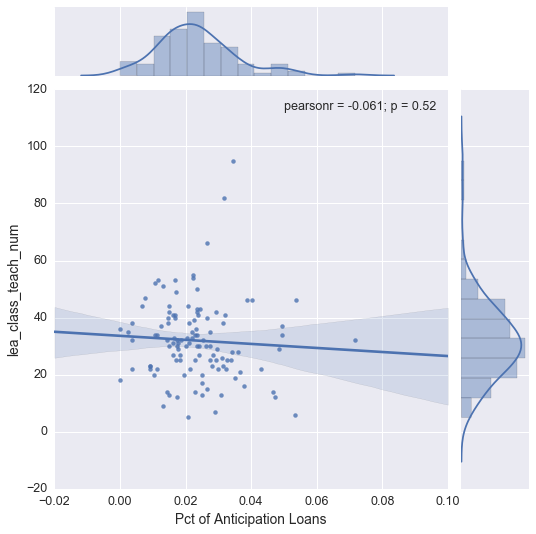

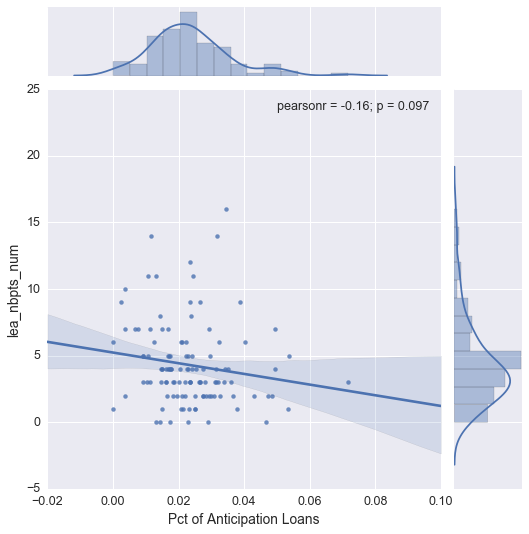

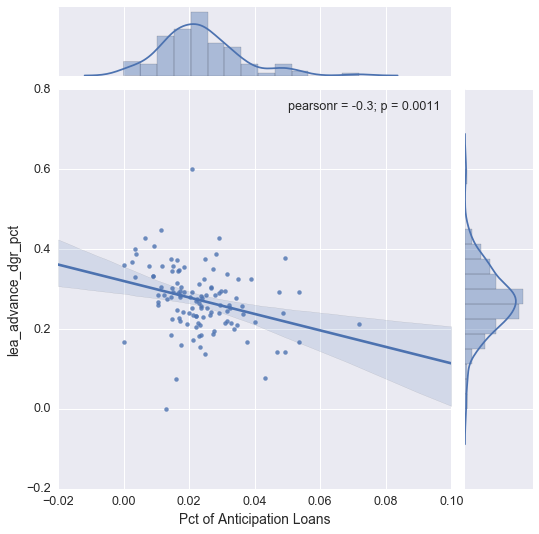

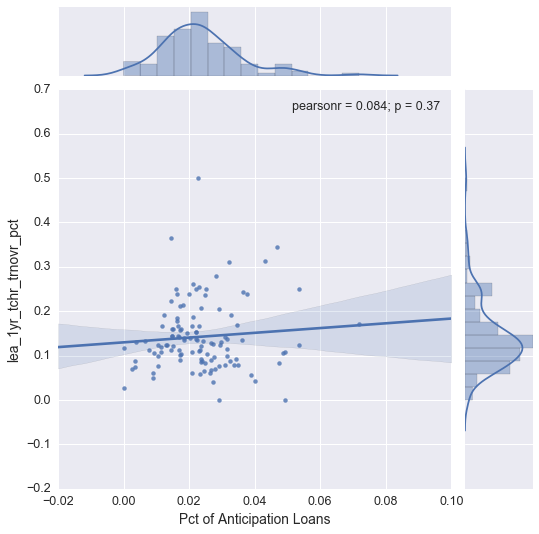

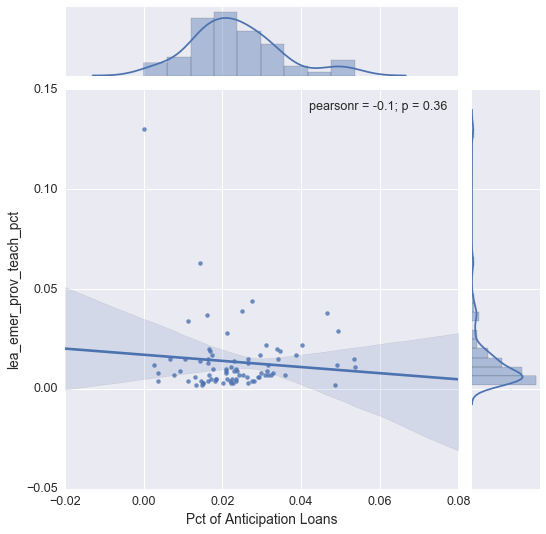

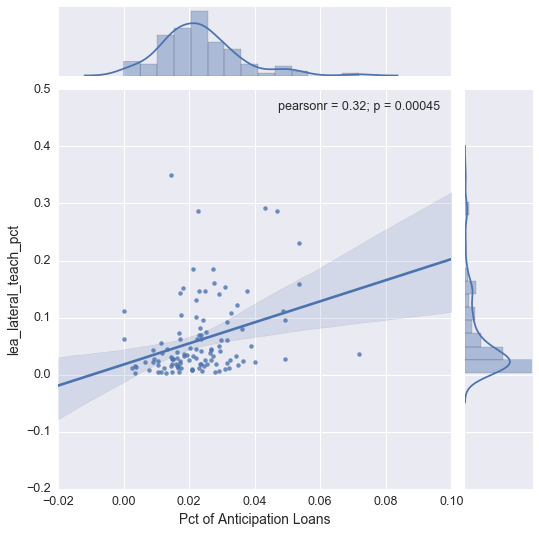

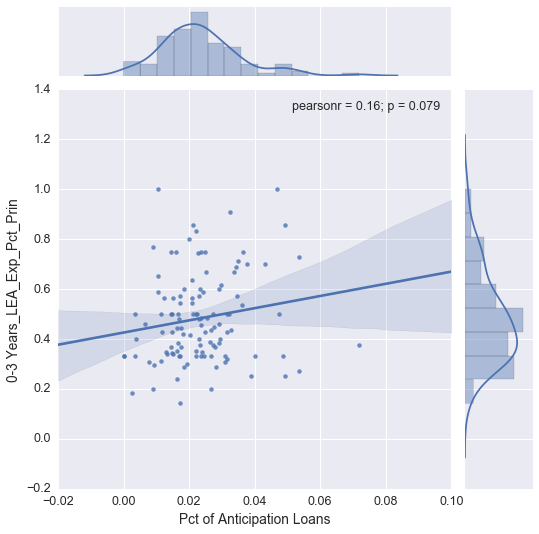

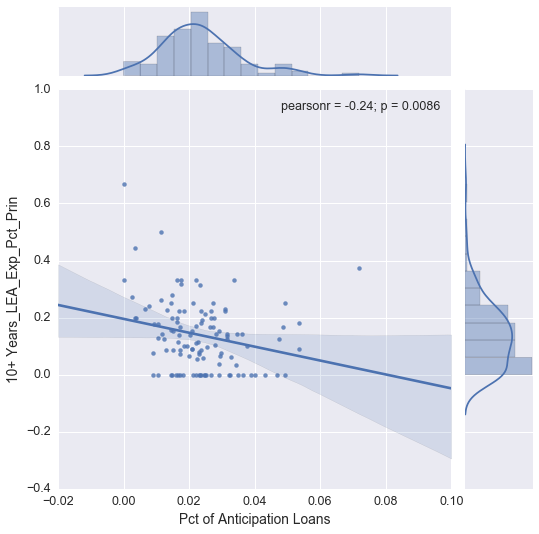

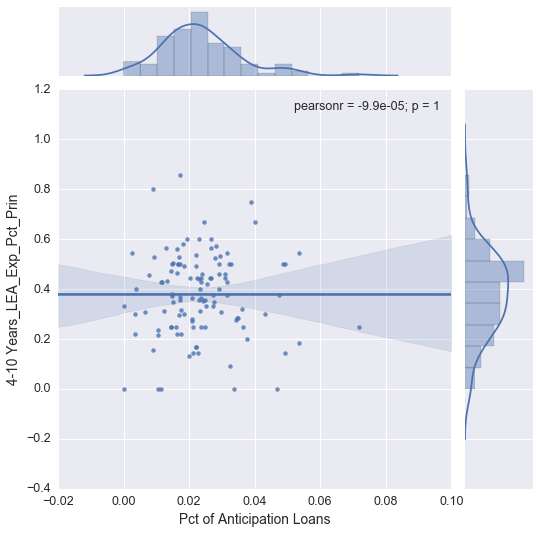

In [16]:
#Create district level charts to compare against number of dependents
for col in leaCols:
    try:
        PlotJoint(x='Pct of Anticipation Loans',y=col, data=irsSchoolDistData)
    except Exception:
        continue

## District Level Relationships with the Percentage of Anticipation Checks
** The following charts use IRS income tax data summarized by NC school district explore the relationship between a school district's IRS reported percentage of anticipation checks and various school district statistics.** 

**Key points to remember:** 
* Correlations are statistically significant at α = 0.05 or lower: they are (highly) unlikely and thus refute the null hypothesis of a zero population correlation.
* Correlations are never lower than -1. A correlation of -1 indicates that the data points in a scatter plot lie exactly on a straight descending line; the two variables are perfectly negatively linearly related.
* A correlation of 0 means that two variables don't have any linear relation whatsoever. However, some non linear relation may exist between the two variables.
* Correlation coefficients are never higher than 1. A correlation coefficient of 1 means that two variables are perfectly positively linearly related; the dots in a scatter plot lie exactly on a straight ascending line.
* Avg Personal Property Taxes = Personal property taxes Amt All / Personal property taxes Ct All

**Key observations include statistically significant positive / negative correlations and are as follows: **
* District salaries as a percent of total expenses decrease as the Percentage of Anticipation Checks increases.
* District services as a percent of total expenses increase as the Percentage of Anticipation Checks increases.
* District supplies as a percent of total expenses increase as the Percentage of Anticipation Checks increases. 
* District federal funding per pupil increases significantly as the Percentage of Anticipation Checks increases.
* District local funding per pupil decreases as the Percentage of Anticipation Checks increases.
* District state funding per pupil increases as the Percentage of Anticipation Checks increases.
* District average SAT scores decrease significantly as the Percentage of Anticipation Checks increases.
* District AP participation percentages decrease as the Percentage of Anticipation Checks increases.
* District AP PCT 3 or above decreases significantly as the Percentage of Anticipation Checks increases.
* District AP IB courses decrease as the Percentage of Anticipation Checks increases.
* District CTE courses increase as the Percentage of Anticipation Checks increases.
* District average daily attendance decreases as the Percentage of Anticipation Checks increases.
* District crime, short and long term suspensions, and expulsions do not appear to be correlated with the Percentage of Anticipation Checks.
*  The average age of a district's media collection decreases as the Percentage of Anticipation Checks increases. 
* District fully licensed teachers decrease as the Percentage of Anticipation Checks increases.
* District teachers with 0-3 years experience increases as the Percentage of Anticipation Checks increases.
* District teachers with 4-10 years experience decreases as the Percentage of Anticipation Checks increases.
* District teachers with 11+ years experience decreases as the Percentage of Anticipation Checks increases.
* District average number of National Board Certified Staff decreases as the Percentage of Anticipation Checks increases. 
* The district's percentage of advanced degrees decrease as the Percentage of Anticipation Checks increases.
* District 1 year teacher turnover percentages increase as the Percentage of Anticipation Checks increases.
* District lateral entry teacher percentages increase as the Percentage of Anticipation Checks increases.
* District principals with 0-3 years experience increase as the Percentage of Anticipation Checks increases.
* District principals with 10+ years experience decrease as the Percentage of Anticipation Checks increases.

### Click on the left side of the charts cell output below to expand all charts for viewing!

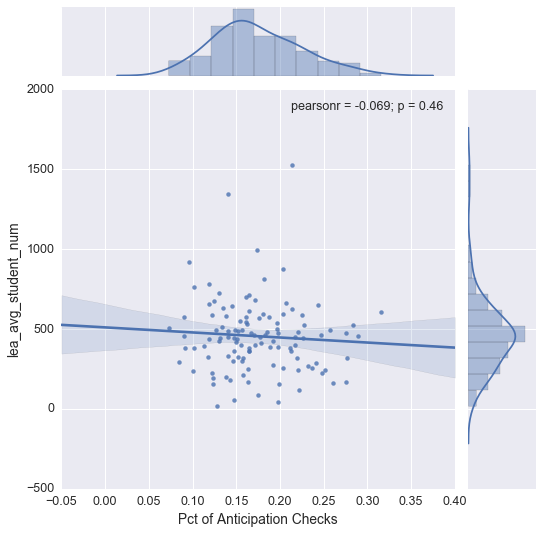

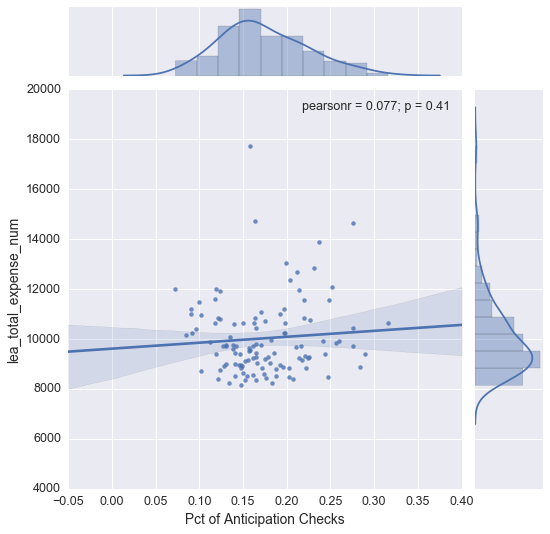

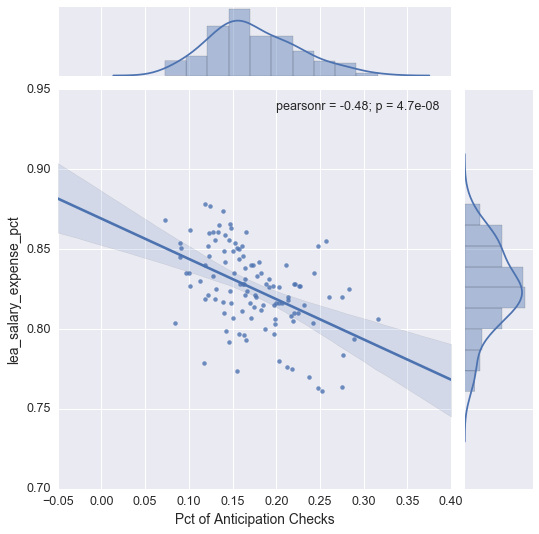

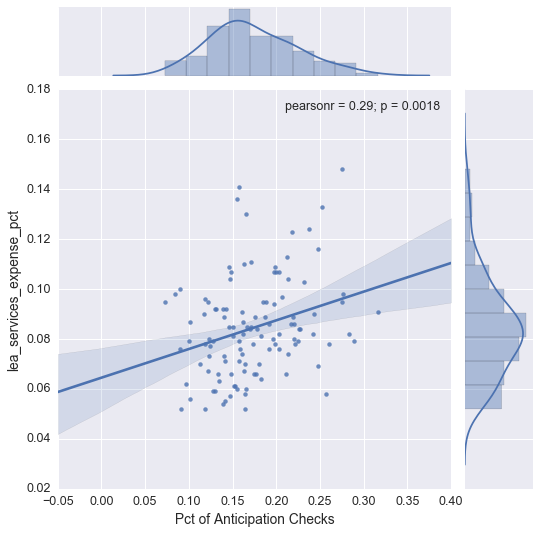

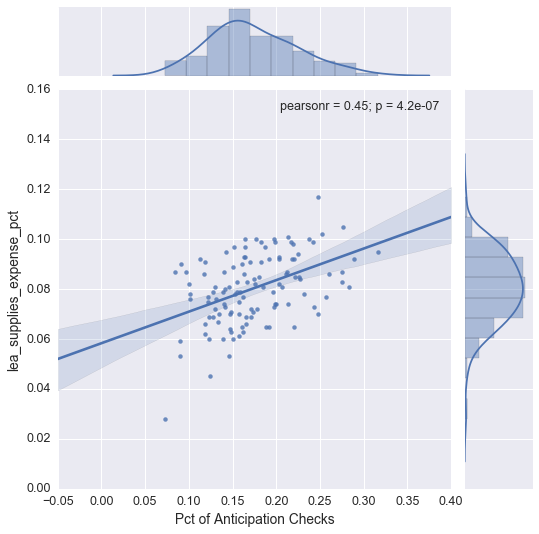

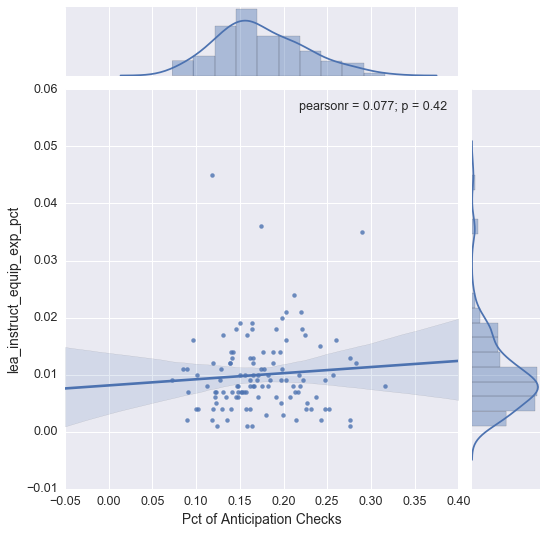

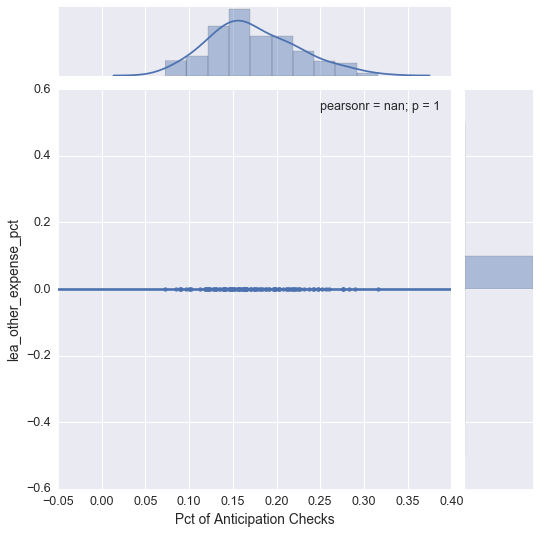

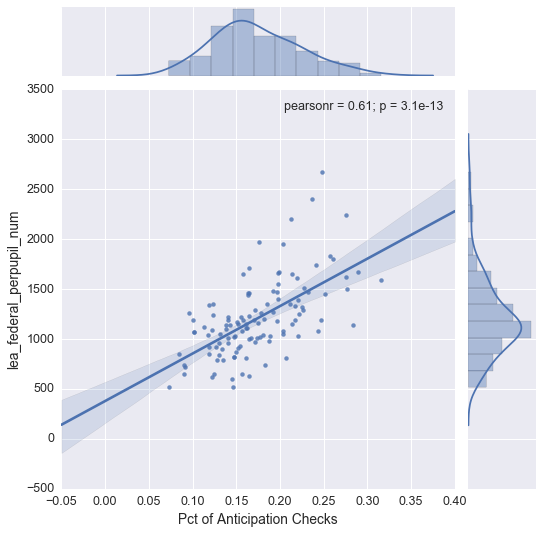

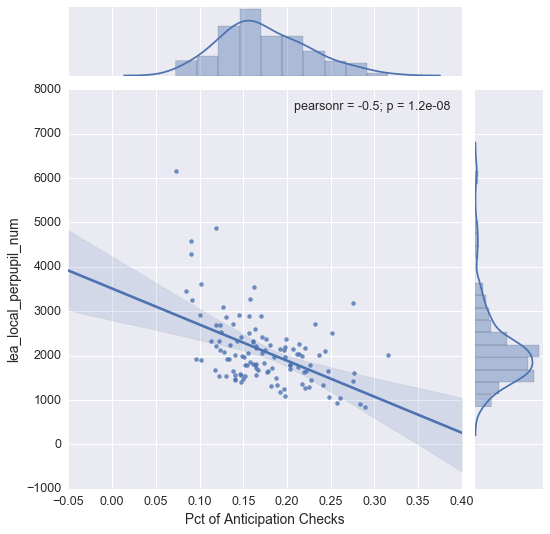

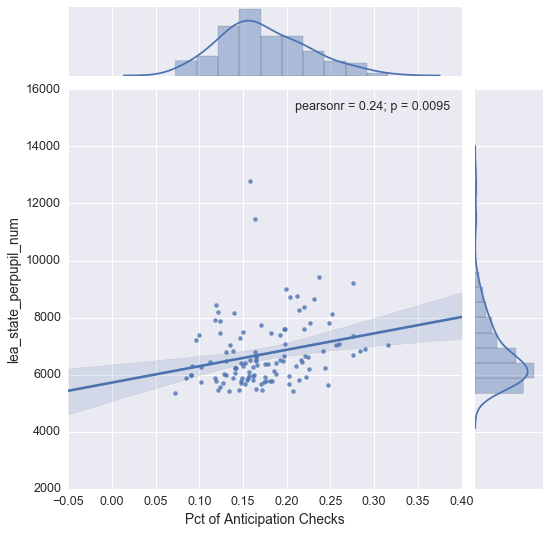

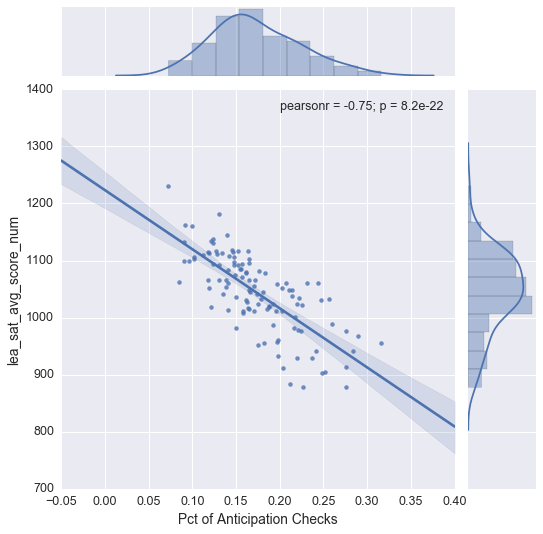

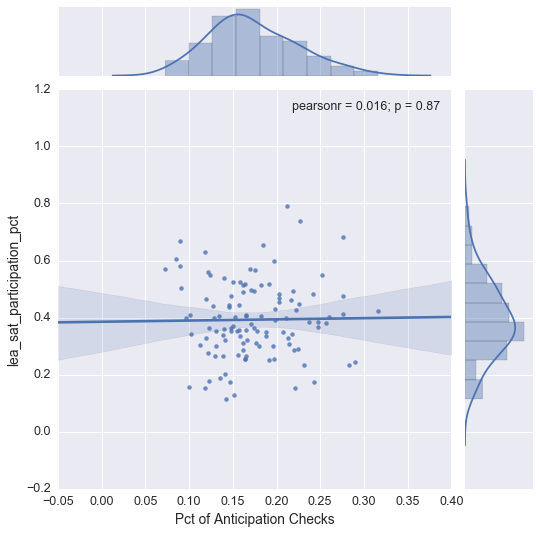

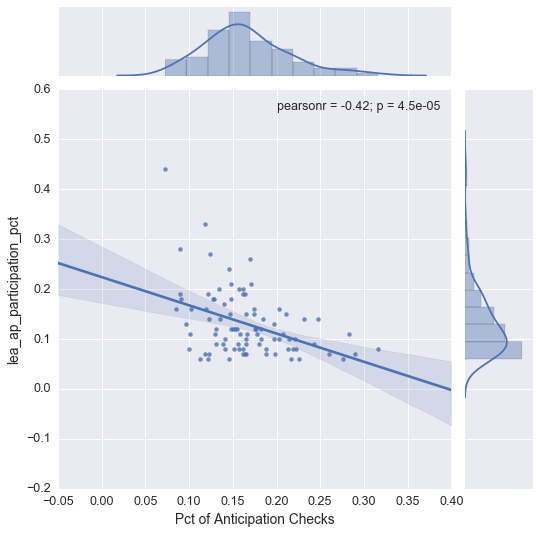

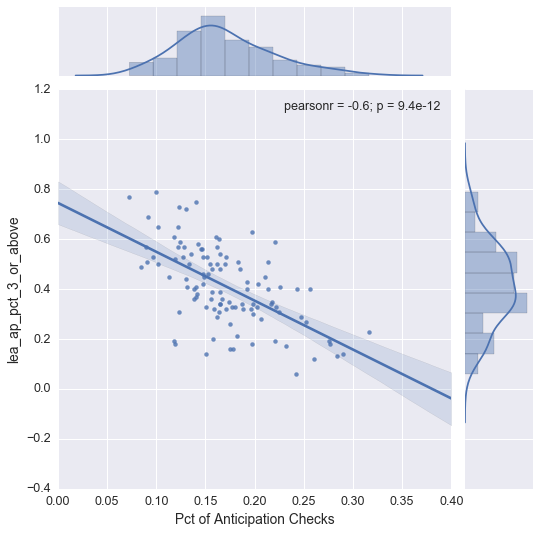

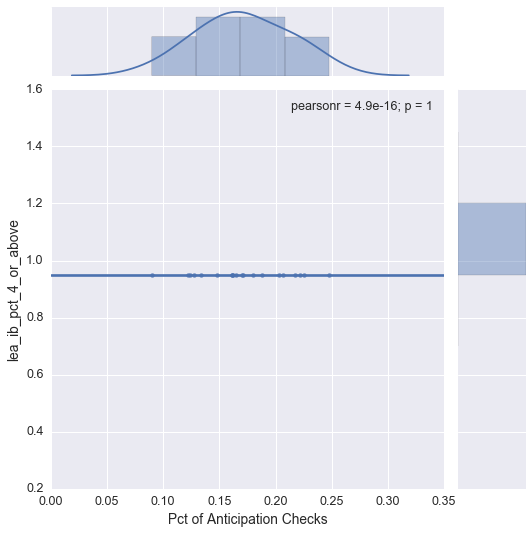

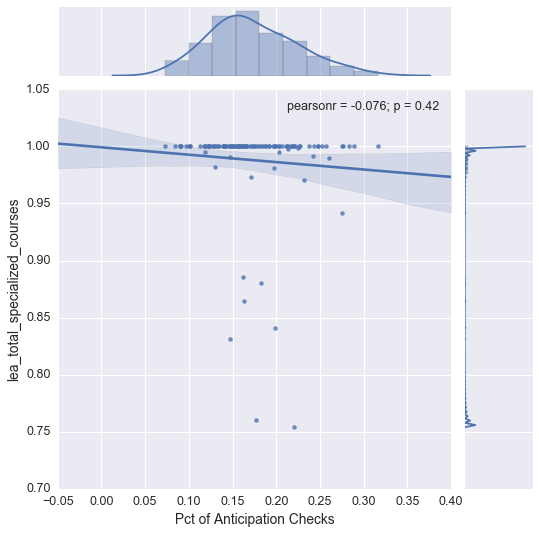

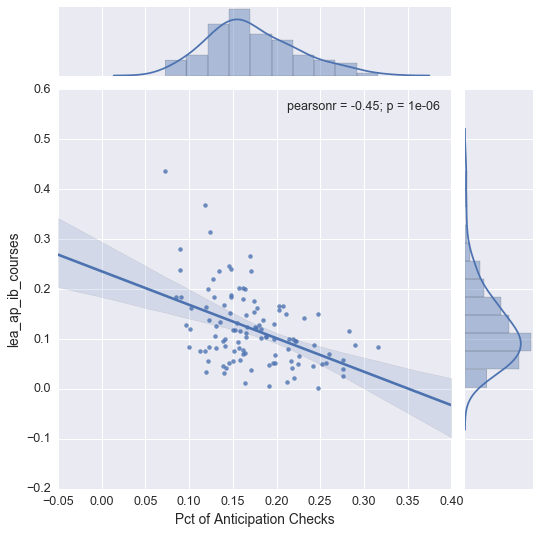

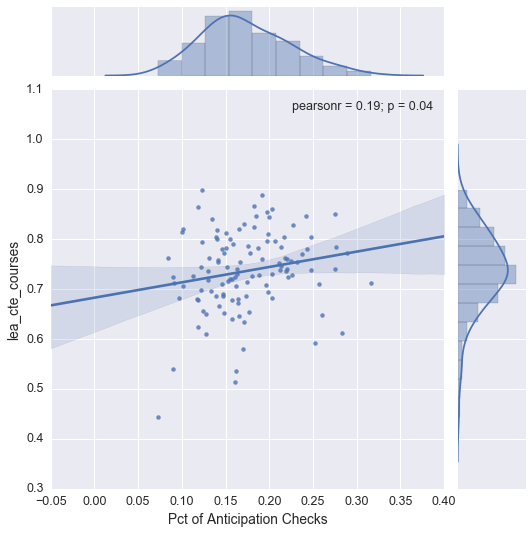

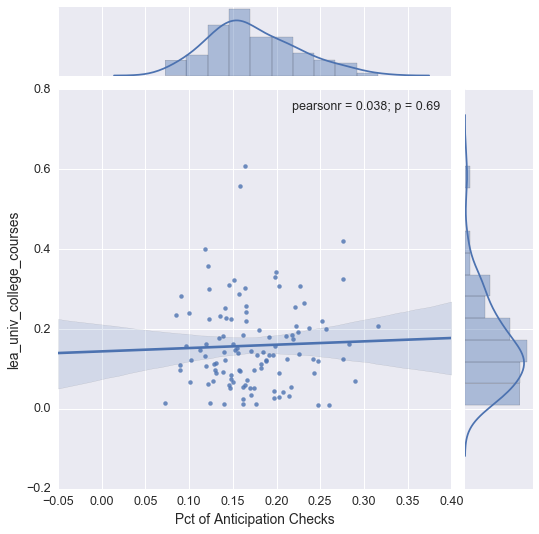

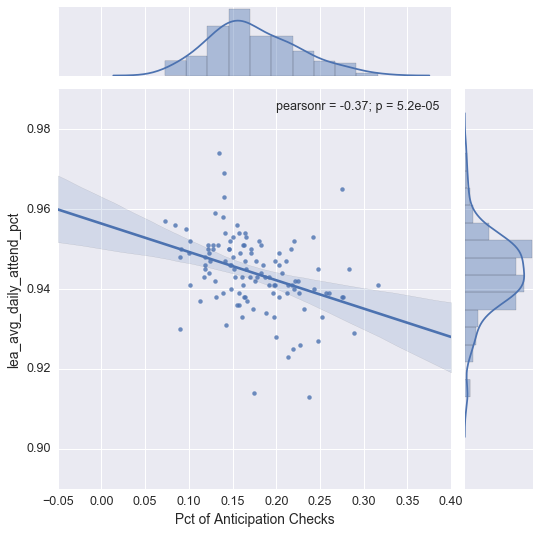

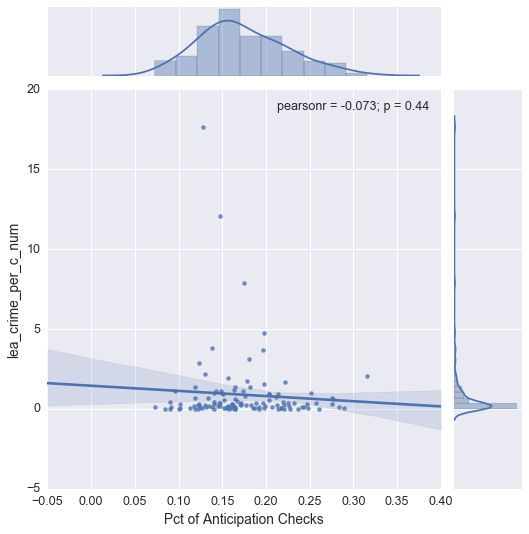

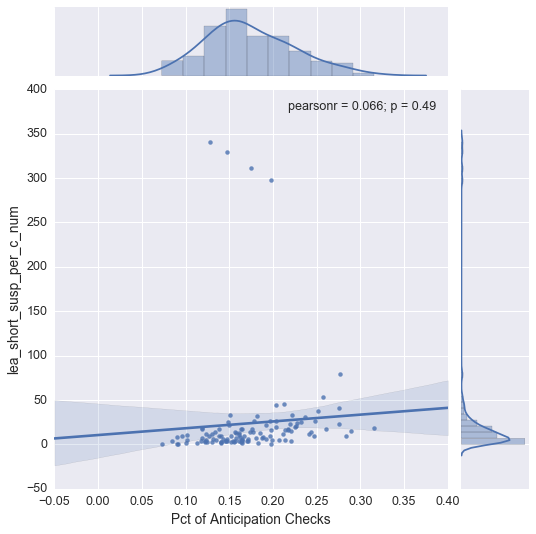

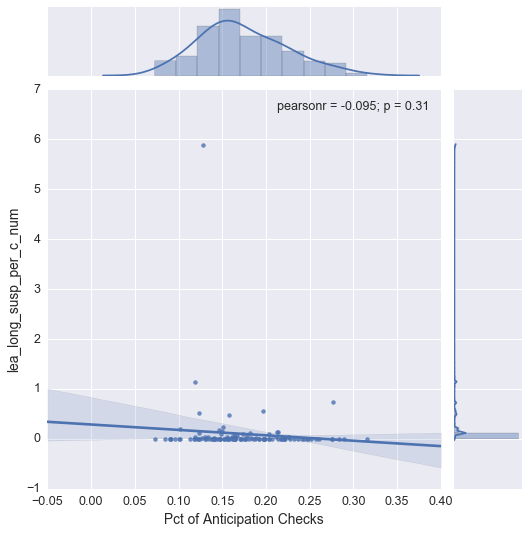

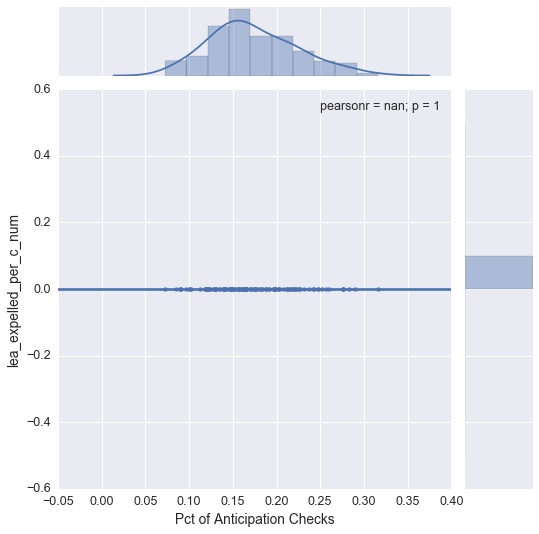

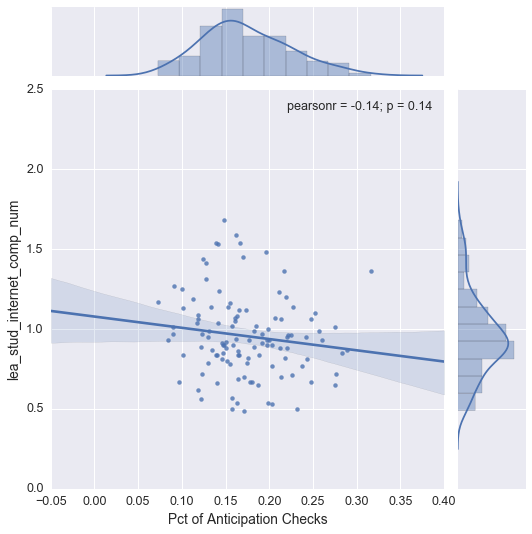

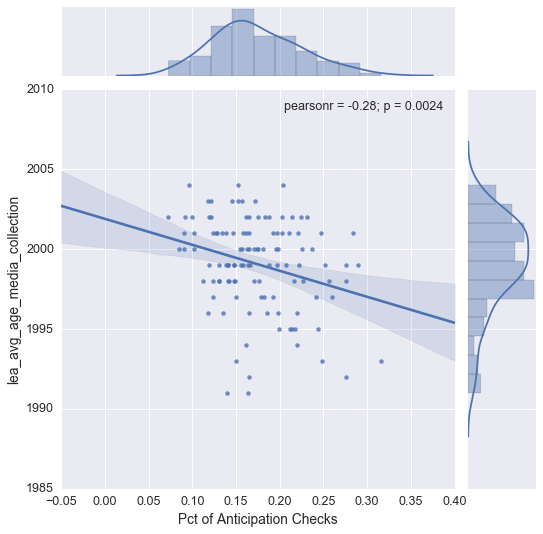

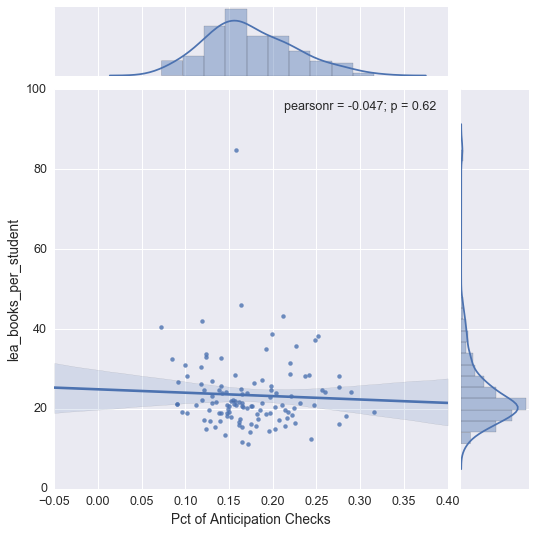

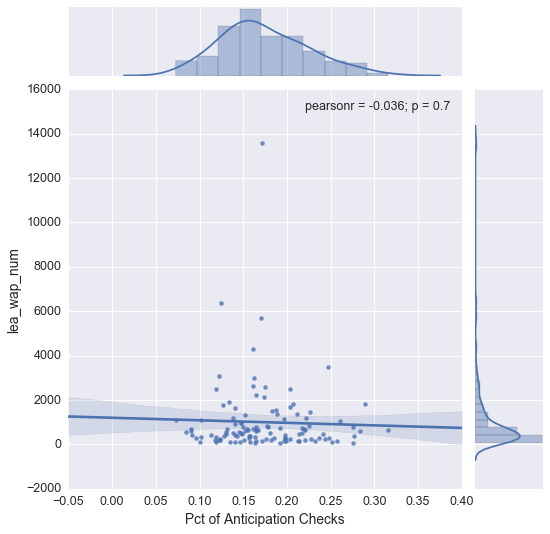

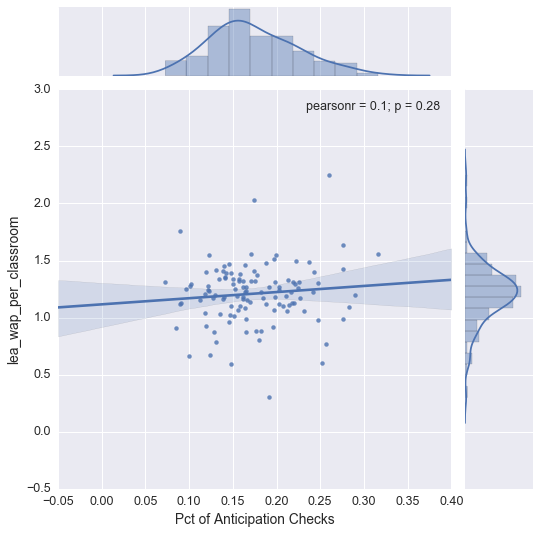

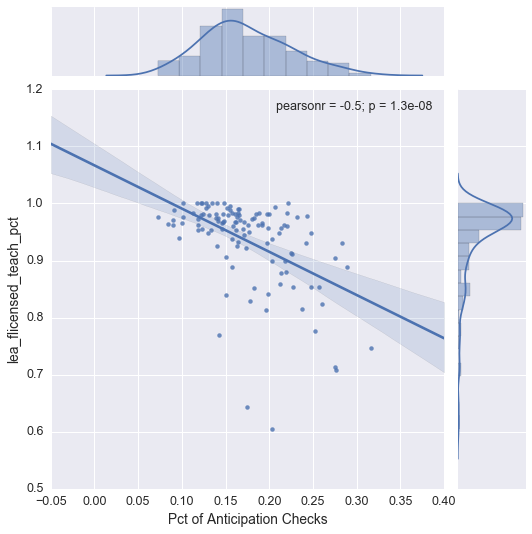

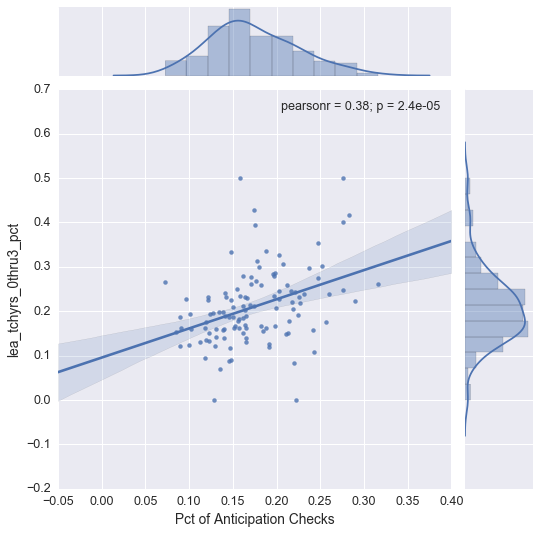

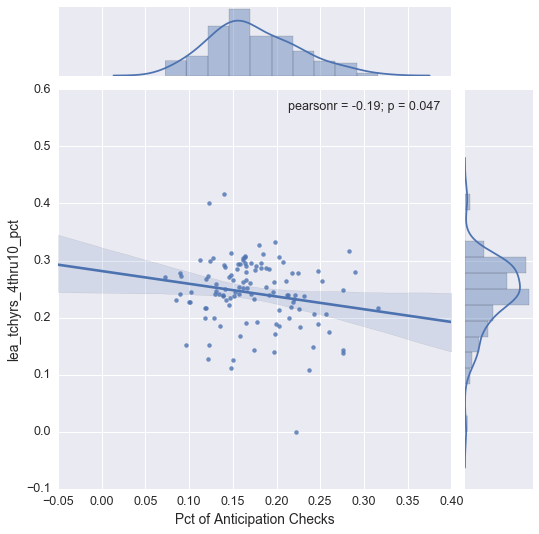

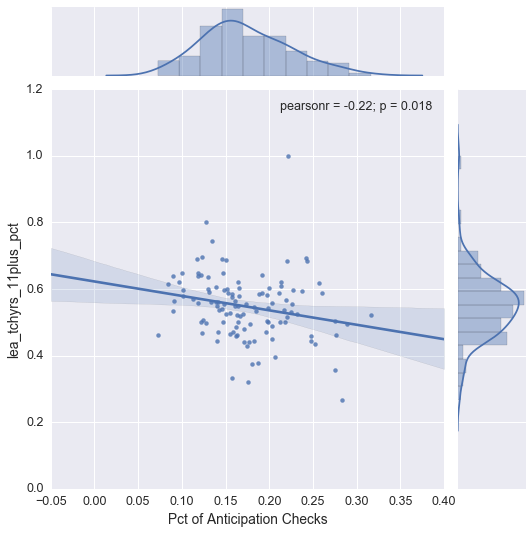

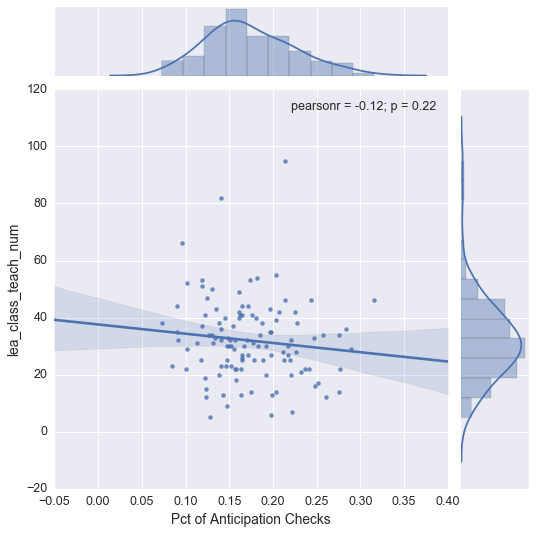

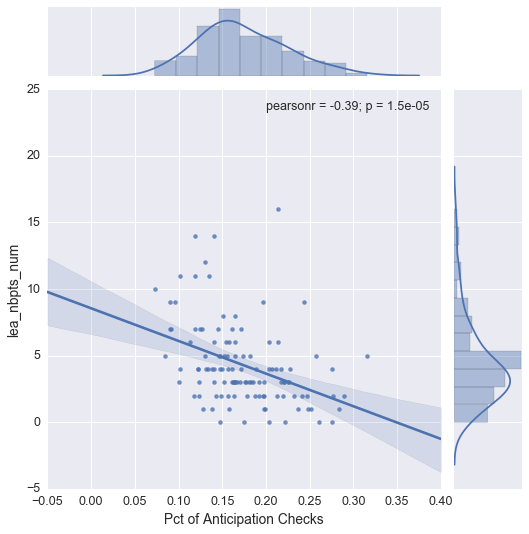

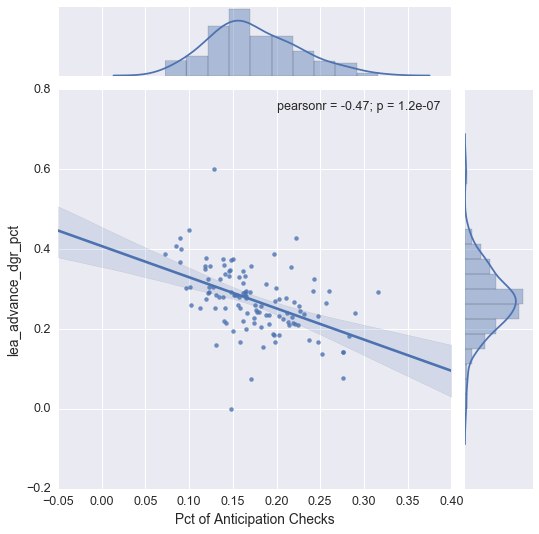

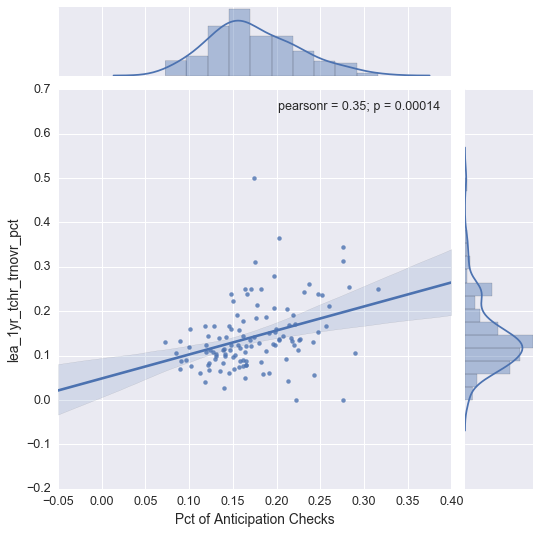

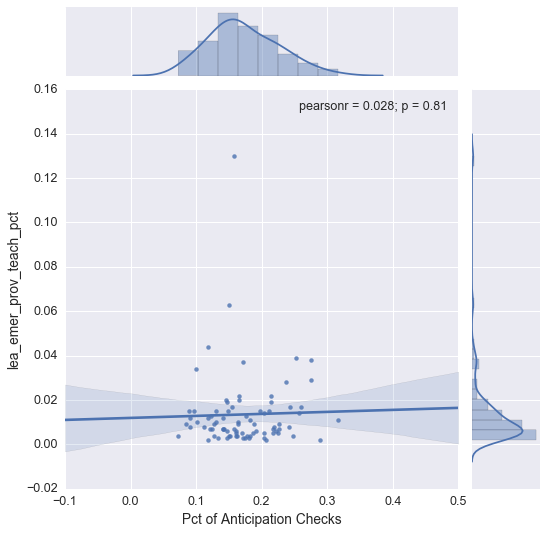

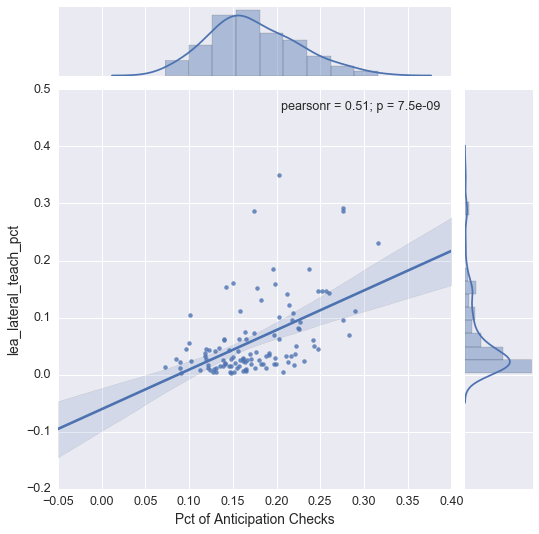

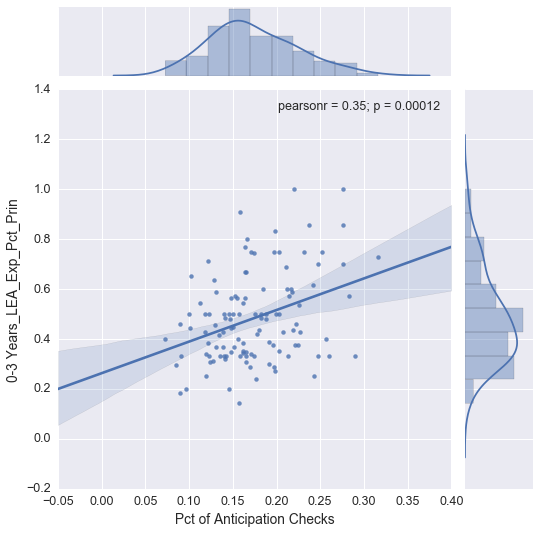

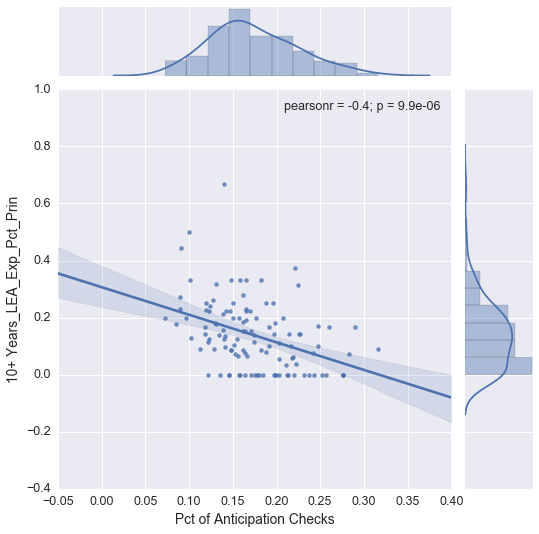

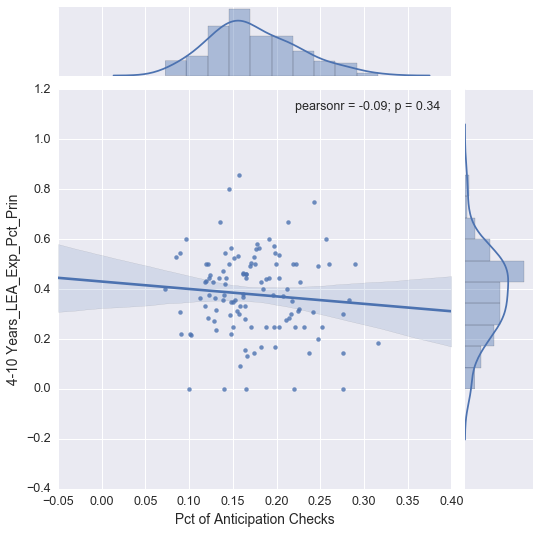

In [17]:
#Create district level charts to compare against number of dependents
for col in leaCols:
    try:
        PlotJoint(x='Pct of Anticipation Checks',y=col, data=irsSchoolDistData)
    except Exception:
        continue

## District Level Relationships with the Percentage of Elderly Returns
** The following charts use IRS income tax data summarized by NC school district explore the relationship between a school district's IRS reported percentage of elderly returns and various school district statistics.** 

**Key points to remember:** 
* Correlations are statistically significant at α = 0.05 or lower: they are (highly) unlikely and thus refute the null hypothesis of a zero population correlation.
* Correlations are never lower than -1. A correlation of -1 indicates that the data points in a scatter plot lie exactly on a straight descending line; the two variables are perfectly negatively linearly related.
* A correlation of 0 means that two variables don't have any linear relation whatsoever. However, some non linear relation may exist between the two variables.
* Correlation coefficients are never higher than 1. A correlation coefficient of 1 means that two variables are perfectly positively linearly related; the dots in a scatter plot lie exactly on a straight ascending line.
* Pct of Farm Returns = Number of farm returns All / Number of returns All  

**Key observations include statistically significant positive / negative correlations and are as follows: **
* District average student numbers decrease as the Percentage of Elderly Returns increases.
* District total expenses increase as the Percentage of Elderly Returns increases.
* District local funding per pupil increases as the Percentage of Elderly Returns increases.
* District state funding per pupil increases as the Percentage of Elderly Returns increases.
* District average SAT scores increase as the Percentage of Elderly Returns increases.
* District AP PCT 3 or above decreases as the Percentage of Elderly Returns increases.
* District AP IB courses decrease as the Percentage of Elderly Returns increases.
* District CTE courses increase as the Percentage of Elderly Returns increases.
* District univ college courses increase as the Percentage of Elderly Returns increases.
* District books per student increase as the Percentage of Elderly Returns increases.
* District wireless access points decrease as the Percentage of Elderly Returns increases.
* District teachers with 0-3 years experience decrease as the Percentage of Elderly Returns increases.
* District teachers with 11+ years experience increases as the Percentage of Elderly Returns increases.
* District class teacher numbers decrease as the Percentage of Elderly Returns increases.
* District percentage of advanced degrees increase as the Percentage of Elderly Returns increases.
* District emer prov teacher percentages increase as the Percentage of Elderly Returns increases.
* District principals with 10+ years experience increase as the Percentage of Elderly Returns increases.
* District principals with 4-10 years experience decrease as the Percentage of Elderly Returns increases.

### Click on the left side of the charts cell output below to expand all charts for viewing!

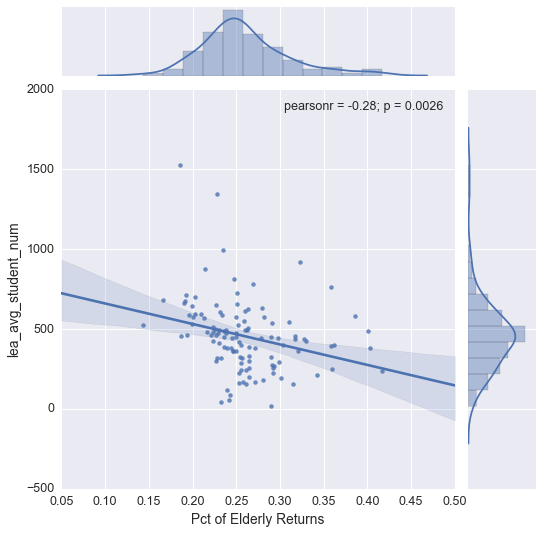

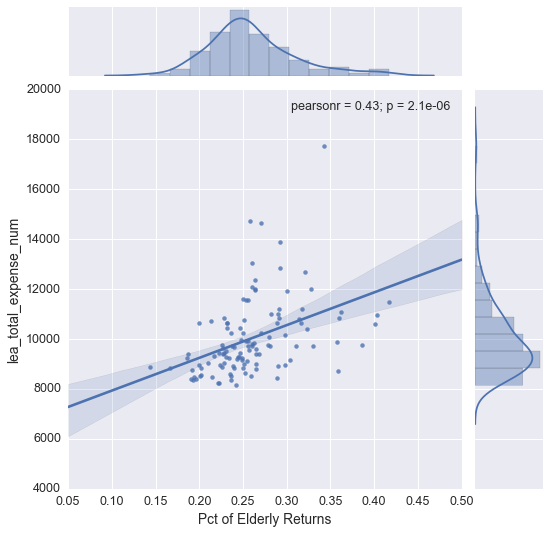

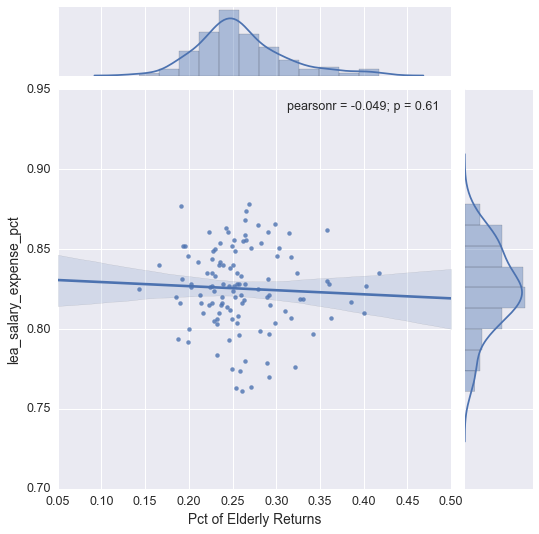

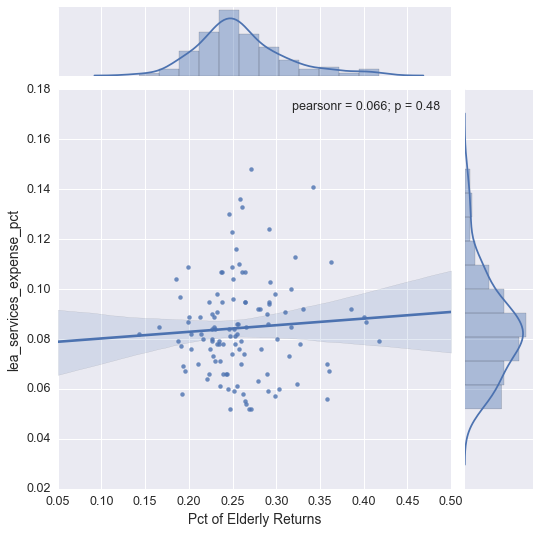

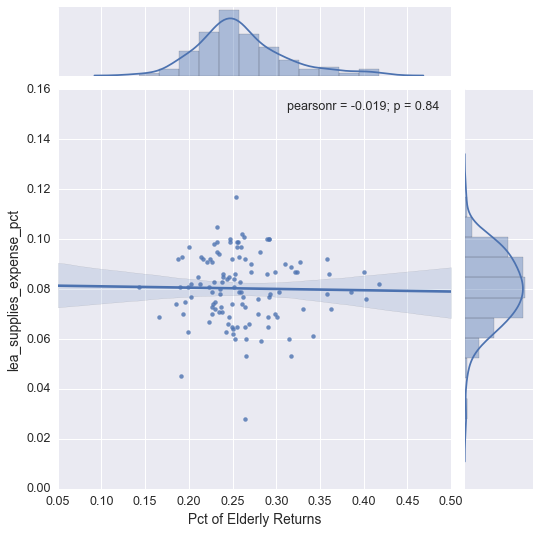

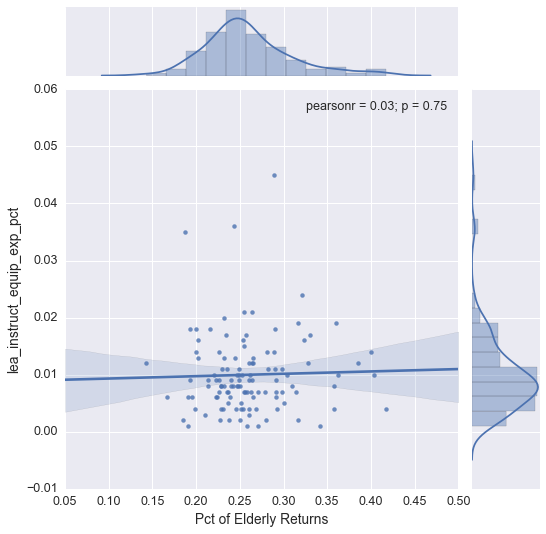

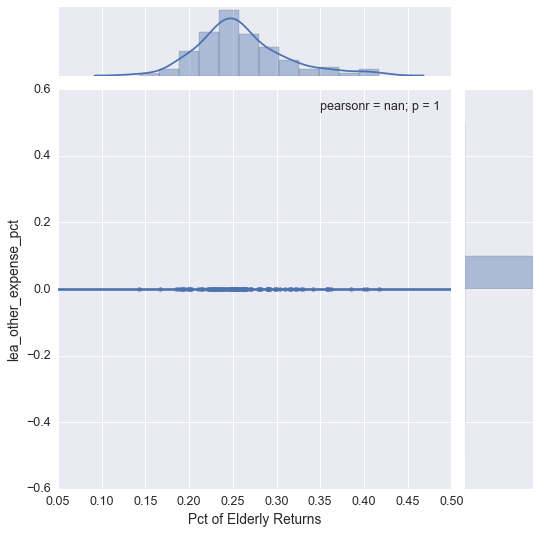

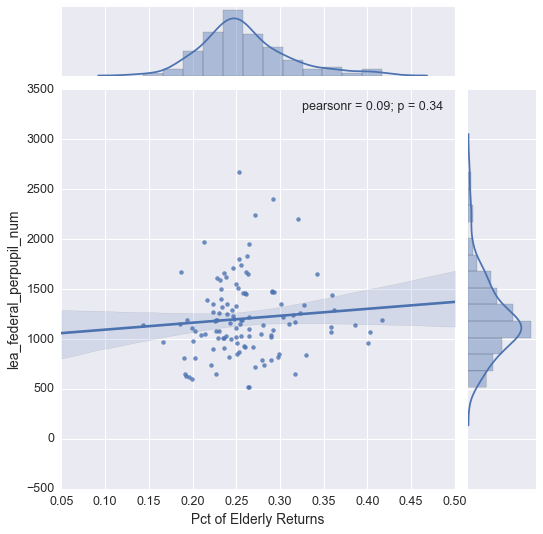

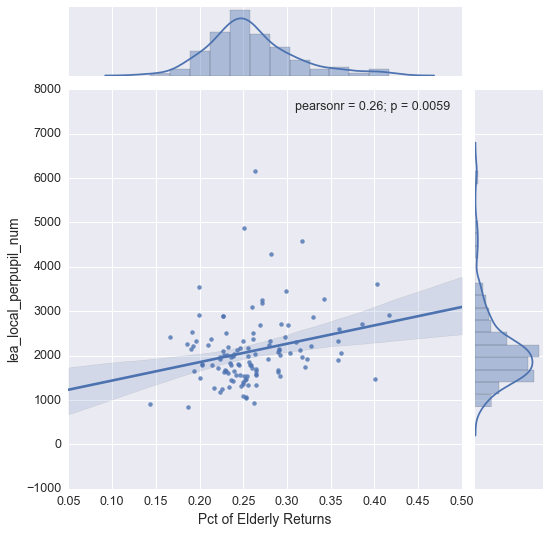

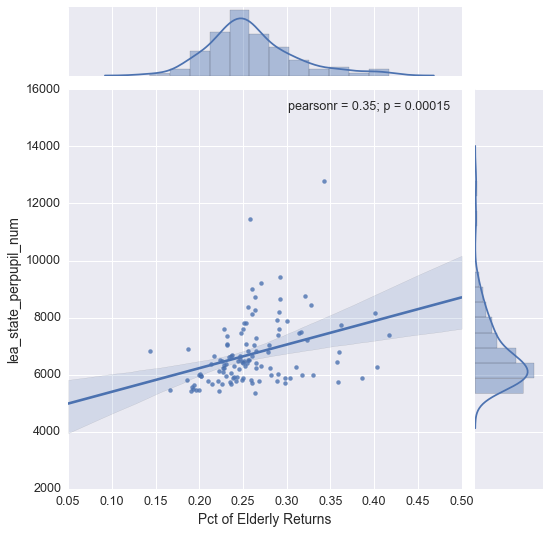

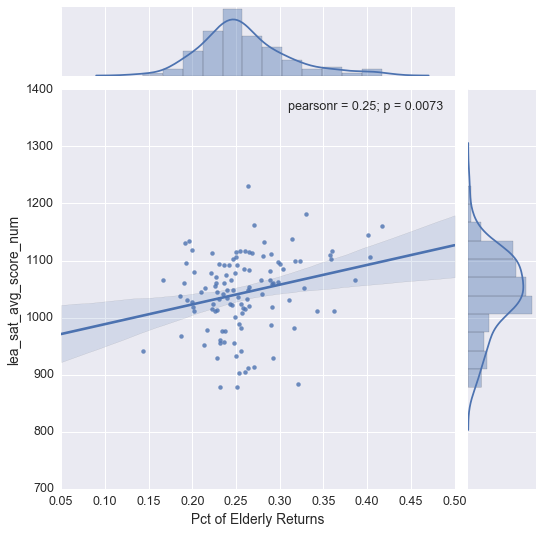

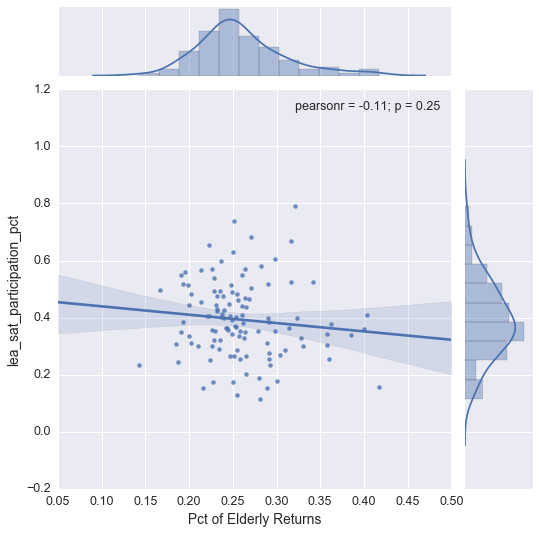

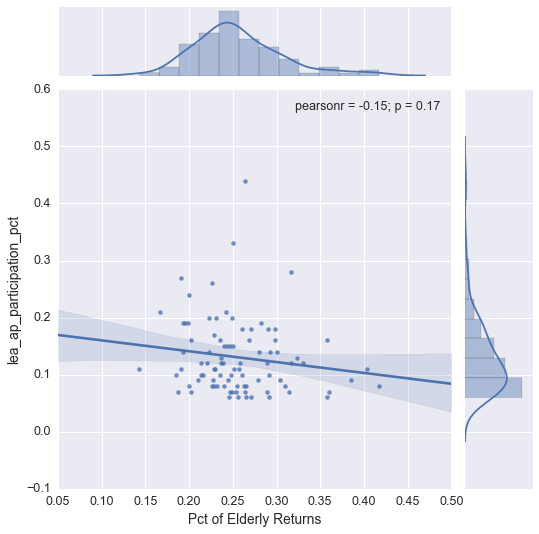

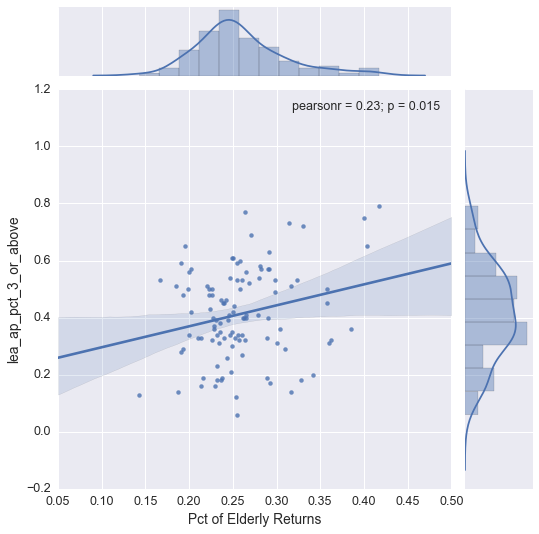

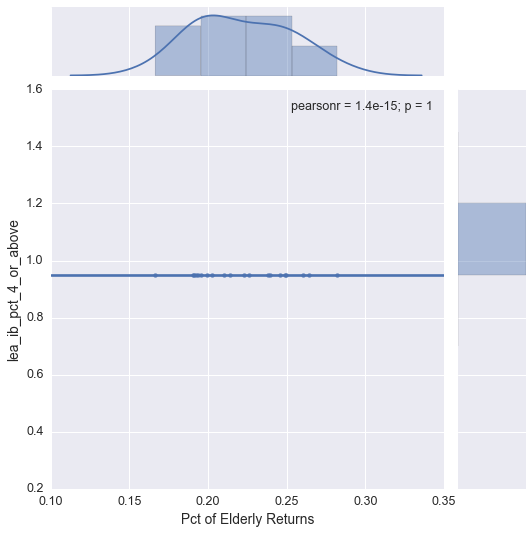

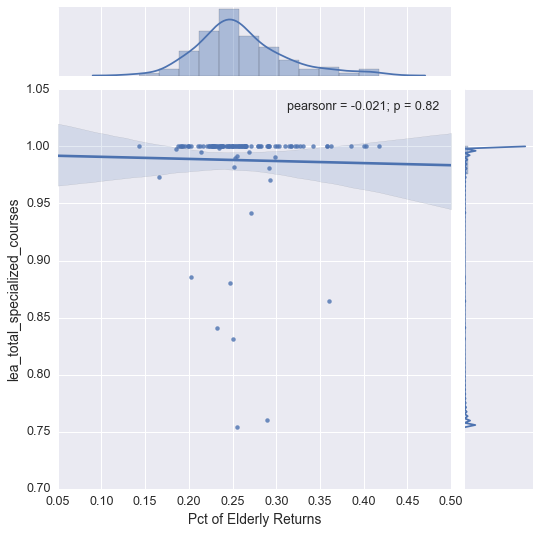

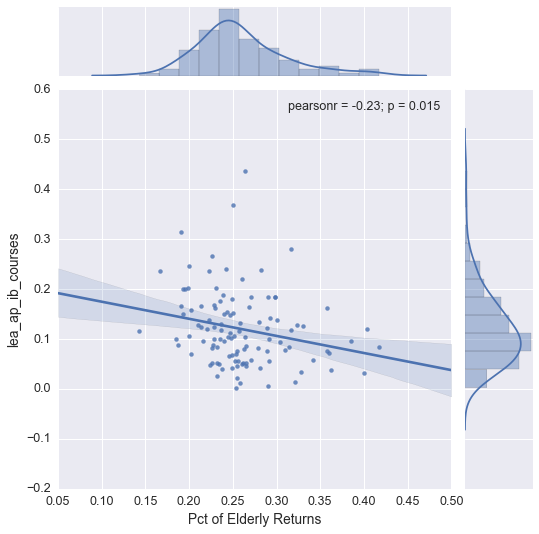

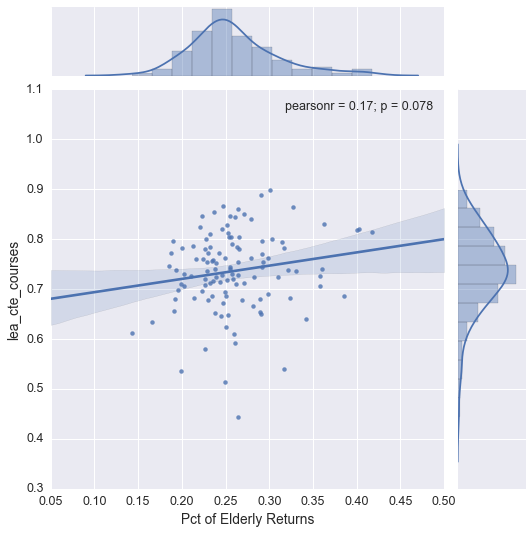

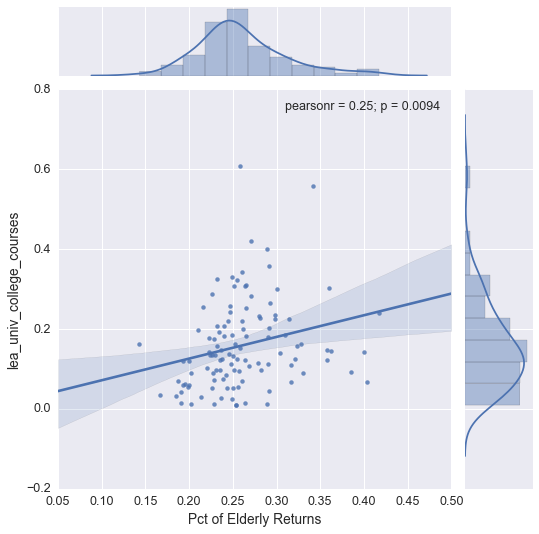

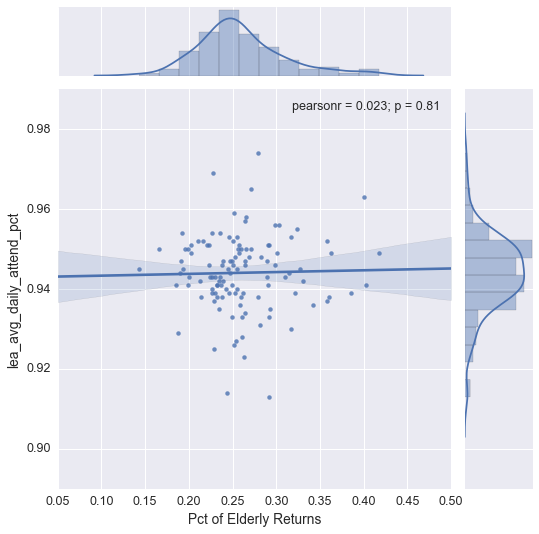

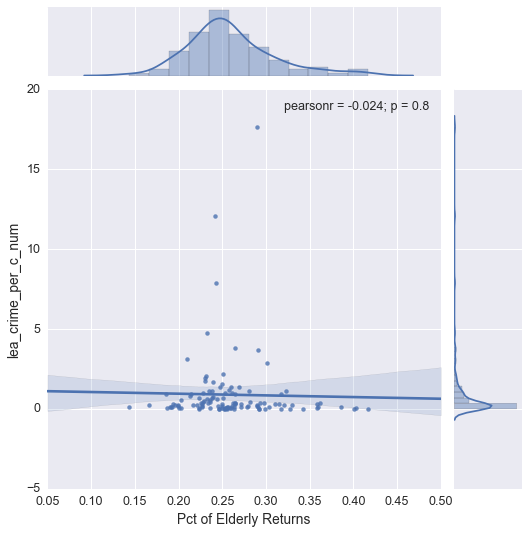

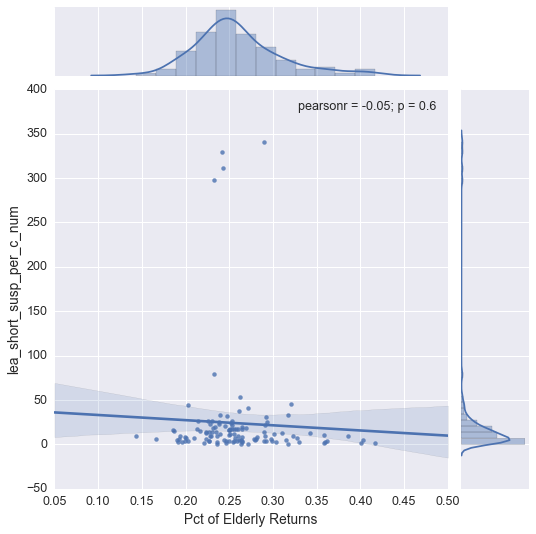

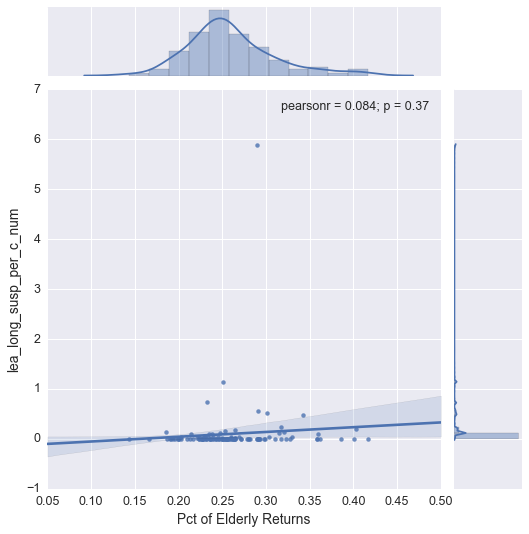

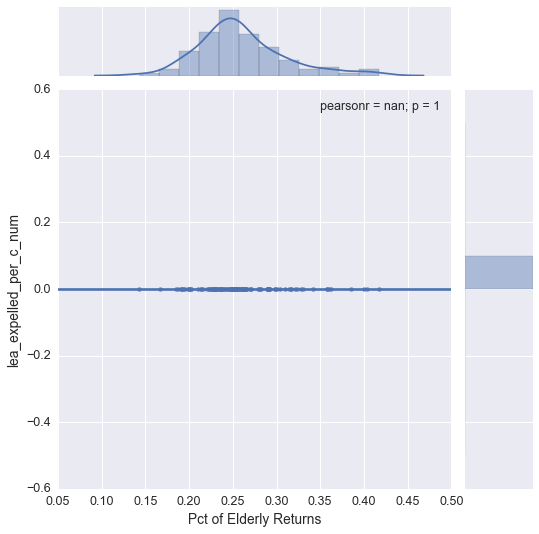

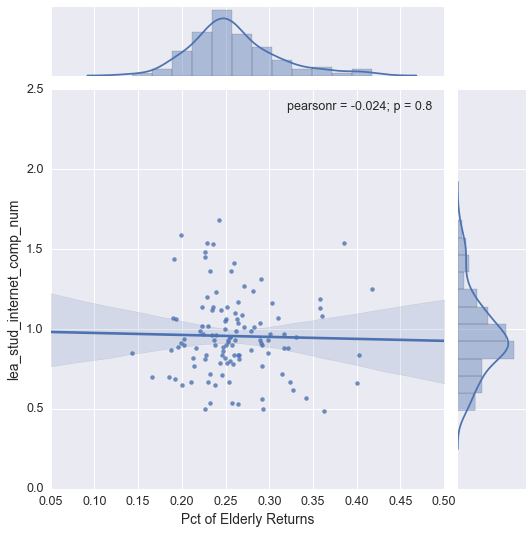

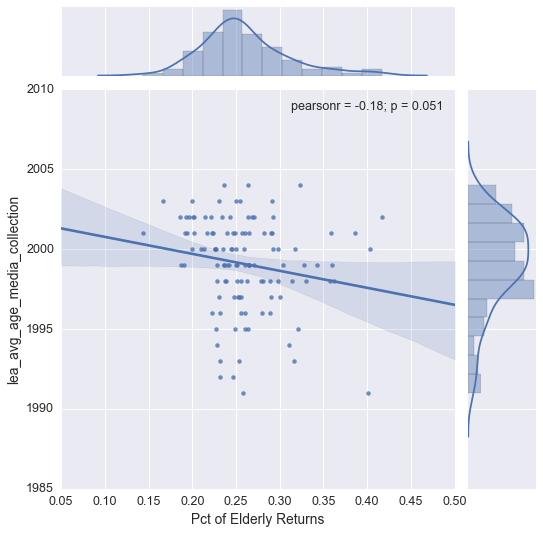

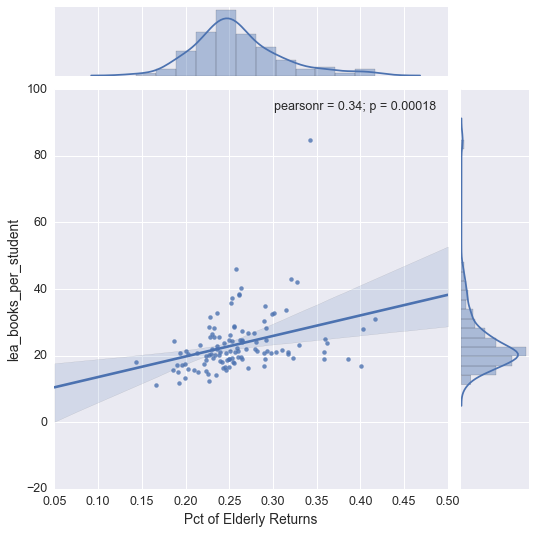

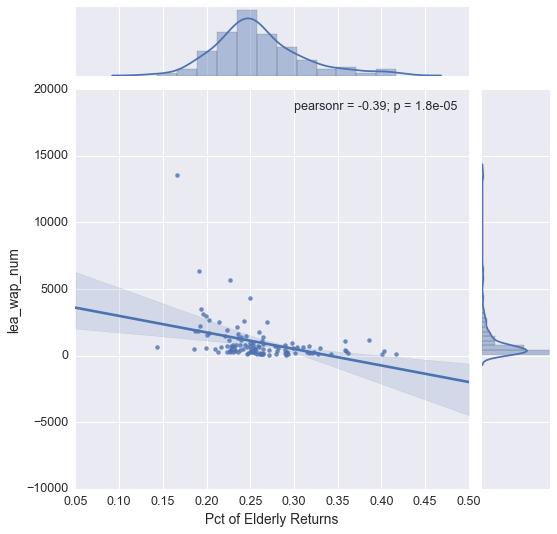

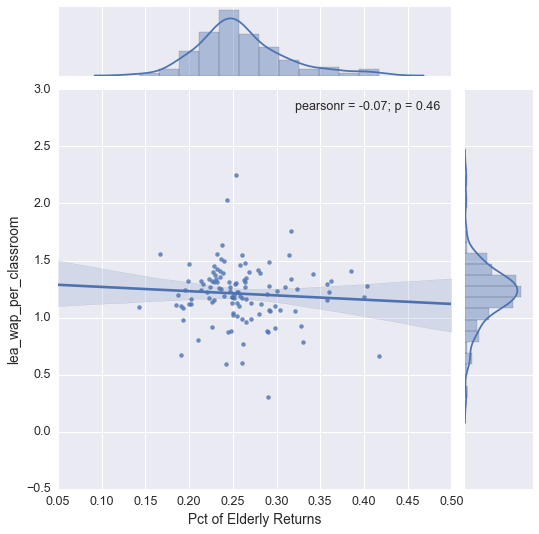

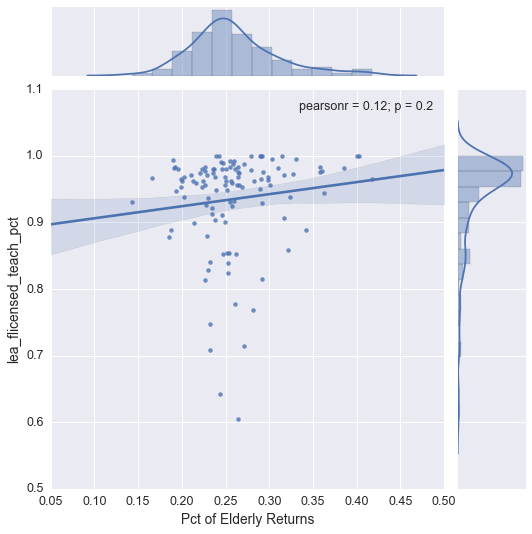

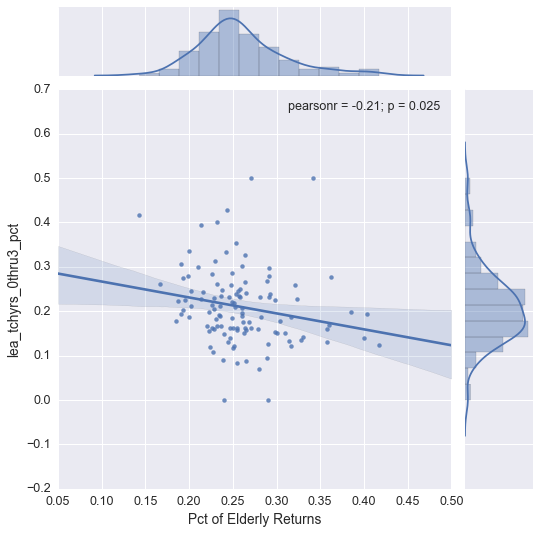

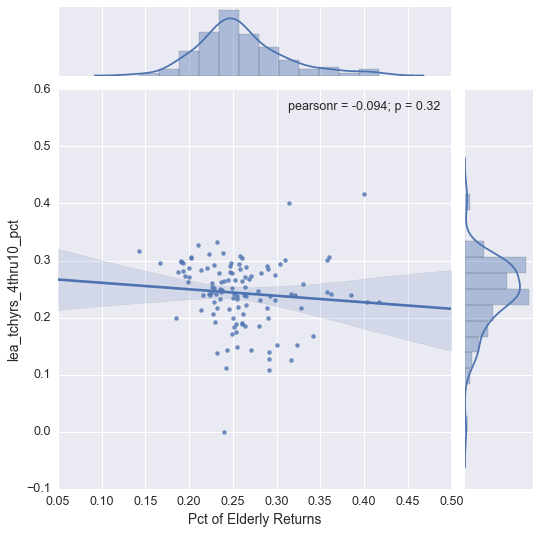

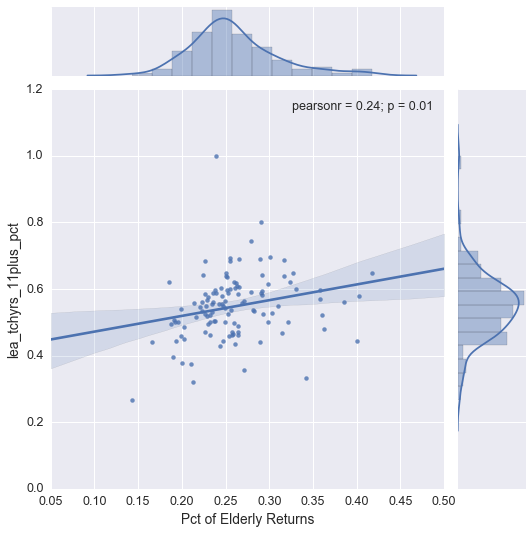

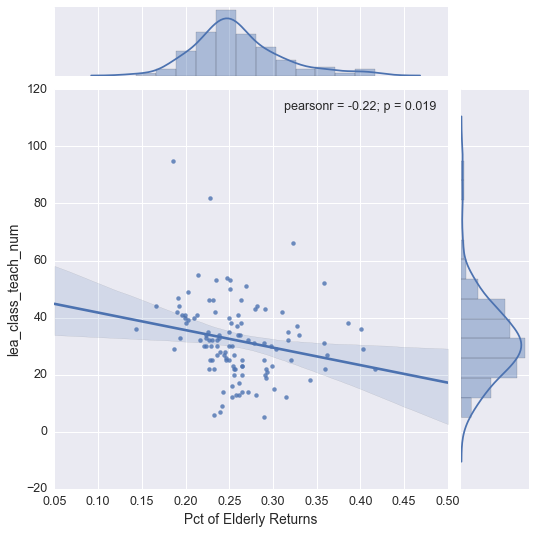

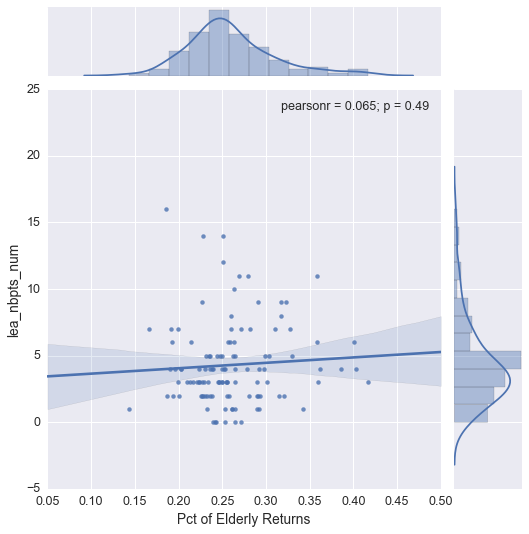

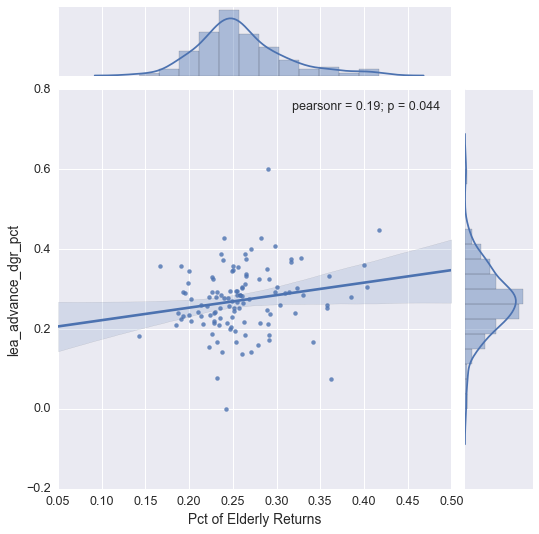

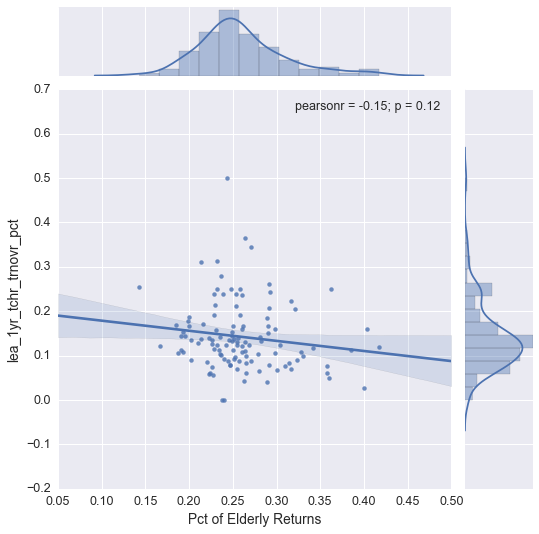

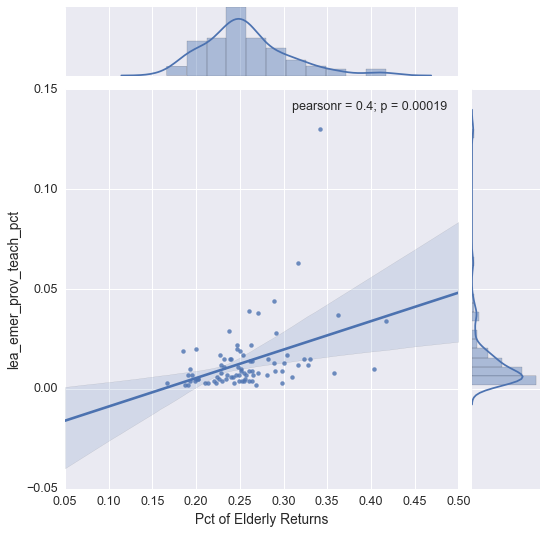

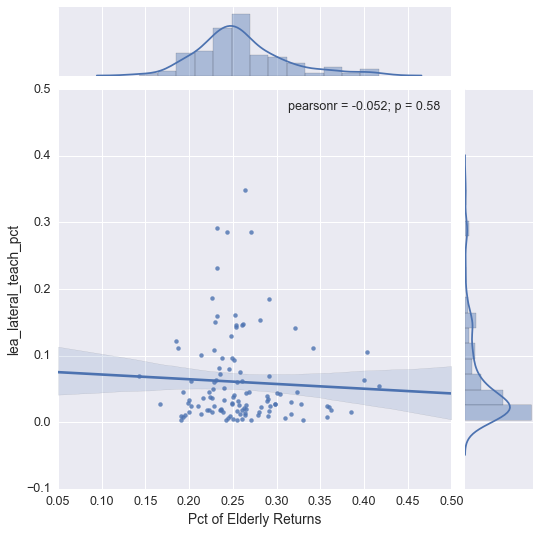

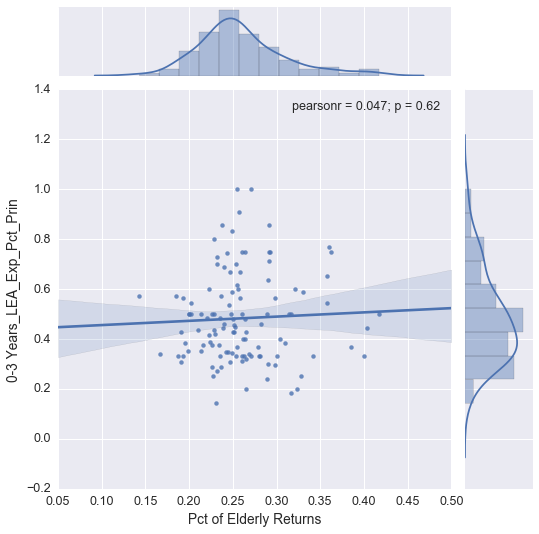

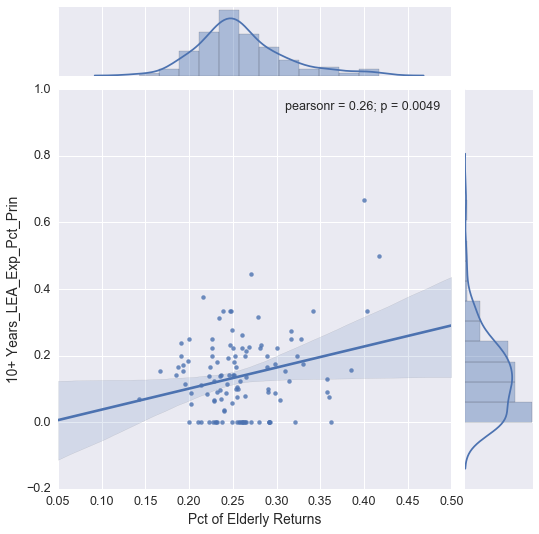

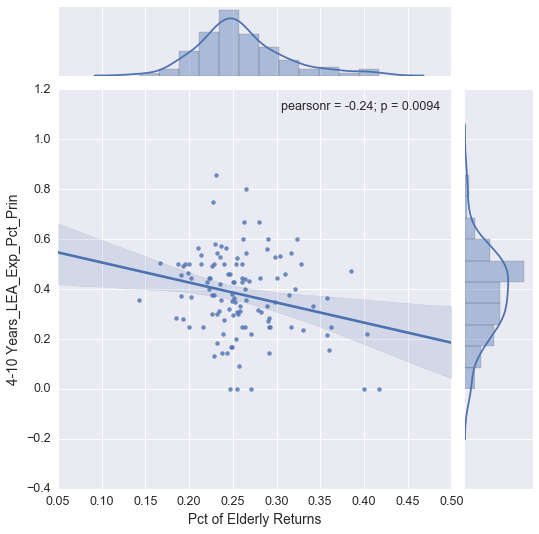

In [18]:
#Create district level charts to compare against number of dependents
for col in leaCols:
    try:
        PlotJoint(x='Pct of Elderly Returns',y=col, data=irsSchoolDistData)
    except Exception:
        continue